# Week 1-2: Comprehensive Error Analysis for 5-Class Health Prediction

**Health XAI Prediction Project**  
**Target:** 5-class health prediction (1=Very Good → 5=Very Bad)  
**Date:** January 2026

## Comprehensive Error Analysis Objectives:

Building upon our baseline modeling results from [03_modeling.ipynb](03_modeling.ipynb), this notebook provides a deep dive into understanding model errors and behavior.

### 🎯 **Analysis Framework:**
✅ **Class Imbalance Analysis**: Understanding the impact of uneven distribution  
✅ **Error Pattern Analysis**: Systematic examination of misclassification patterns  
✅ **Feature Impact Analysis**: Which features drive errors vs correct predictions  
✅ **Subgroup Performance**: Error analysis across different population segments  
✅ **Model Behavior Analysis**: Training dynamics and overfitting patterns  
✅ **Confidence Analysis**: Model uncertainty and prediction confidence  
✅ **Health-Specific Insights**: Domain-relevant error interpretation  

### 📊 **Key Metrics from Baseline (Week 1-2):**
- **Best Model**: XGBoost (49.0% accuracy)
- **Dataset**: 42,339 samples with 5-class distribution  
- **Challenge**: Class imbalance (Very Bad: 1.1%, Bad: 6.0%)
- **Opportunity**: Identify improvement areas for Week 3-4 optimization

In [1]:
# ============================================================================
# IMPORTS AND SETUP
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings
import json
import joblib
import torch
from collections import Counter
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, 
    precision_recall_curve, roc_curve, roc_auc_score
)
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy.stats import chi2_contingency, pearsonr
import itertools

warnings.filterwarnings('ignore')

# Add project root to path
sys.path.append('..')
from src.train_models import FeedForwardNN

# Visualization setup
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# Project paths
PROJECT_ROOT = Path('..').resolve()
DATA_PATH = PROJECT_ROOT / "data" / "processed" / "health_clean.csv"
RESULTS_DIR = PROJECT_ROOT / "results"
MODELS_DIR = RESULTS_DIR / "models"
PLOTS_DIR = RESULTS_DIR / "plots"
ERROR_ANALYSIS_DIR = RESULTS_DIR / "error_analysis"

# Create directories
for directory in [PLOTS_DIR, ERROR_ANALYSIS_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

print("✅ Setup complete!")
print(f"📁 Project root: {PROJECT_ROOT}")
print(f"📊 Results directory: {RESULTS_DIR}")
print(f"🔍 Error analysis output: {ERROR_ANALYSIS_DIR}")

✅ Setup complete!
📁 Project root: /Users/peter/Desktop/health_xai_prediction
📊 Results directory: /Users/peter/Desktop/health_xai_prediction/results
🔍 Error analysis output: /Users/peter/Desktop/health_xai_prediction/results/error_analysis


In [ ]:
# ============================================================================
# DATA LOADING AND MODEL SETUP
# ============================================================================

# Load data and models from baseline modeling
print("LOADING TRAINED MODELS AND DATA")
print("=" * 60)

# Load models
models = {}
model_names = ['logistic_regression', 'random_forest', 'xgboost', 'svm']

for name in model_names:
    model_file = MODELS_DIR / f"{name}.joblib"
    if model_file.exists():
        models[name] = joblib.load(model_file)
        print(f"✓ Loaded {name}")

# Load neural network separately (PyTorch model)
nn_model_path = MODELS_DIR / "neural_network.pkl"
nn_config_path = MODELS_DIR / "neural_network_config.json"

if nn_model_path.exists() and nn_config_path.exists():
    try:
        # Define the neural network class
        class FeedForwardNN(nn.Module):
            def __init__(self, input_dim, hidden_dims, num_classes, dropout_rate=0.3):
                super(FeedForwardNN, self).__init__()
                
                layers = []
                prev_dim = input_dim
                
                for hidden_dim in hidden_dims:
                    layers.extend([
                        nn.Linear(prev_dim, hidden_dim),
                        nn.ReLU(),
                        nn.Dropout(dropout_rate)
                    ])
                    prev_dim = hidden_dim
                
                layers.append(nn.Linear(prev_dim, num_classes))
                self.network = nn.Sequential(*layers)
                
            def forward(self, x):
                return self.network(x)
        
        # Load config and model
        with open(nn_config_path, 'r') as f:
            nn_config = json.load(f)
        
        nn_model = FeedForwardNN(
            input_dim=nn_config['input_dim'],
            hidden_dims=tuple(nn_config['hidden_dims']),
            num_classes=nn_config['num_classes']
        )
        
        nn_model.load_state_dict(torch.load(nn_model_path, map_location='cpu'))
        nn_model.eval()
        
        models['neural_network'] = nn_model
        model_names.append('neural_network')
        print(f"✓ Loaded neural_network")
    except Exception as e:
        print(f"✗ Could not load neural_network: {e}")

# Load data splits
data_splits_path = MODELS_DIR / "data_splits.joblib"
if data_splits_path.exists():
    splits = joblib.load(data_splits_path)
    X_train = splits['X_train']
    X_val = splits['X_val'] 
    X_test = splits['X_test']
    y_train = splits['y_train']
    y_val = splits['y_val']
    y_test = splits['y_test']
    feature_names = X_train.columns.tolist()
    print(f"✓ Loaded data splits: train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")
else:
    print("✗ Data splits not found. Please run baseline modeling first.")
    raise FileNotFoundError("Run baseline modeling notebook first to create data splits")

# Define class names for 5-class health prediction
class_names = ['Very Good', 'Good', 'Fair', 'Bad', 'Very Bad']

print(f"\n📊 Dataset Overview:")
print(f"Features: {X_train.shape[1]}")
print(f"Classes: {len(class_names)} {class_names}")
print(f"Models loaded: {len(models)}")
print(f"Test set: {len(X_test)} samples")

# Get class distribution
print(f"\n🏷️ Test Set Class Distribution:")
class_dist = pd.Series(y_test).value_counts().sort_index()
for i, (class_idx, count) in enumerate(class_dist.items()):
    pct = count / len(y_test) * 100
    print(f"  {class_idx} ({class_names[class_idx-1]}): {count:,} samples ({pct:.1f}%)")

LOADING TRAINED MODELS AND DATA
✓ Loaded logistic_regression
✓ Loaded random_forest
✓ Loaded xgboost
✓ Loaded svm
✗ Could not load neural_network: name 'nn' is not defined
✓ Loaded data splits: train=29637, val=6351, test=6351

📊 Dataset Overview:
Features: 19
Classes: 5 ['Very Good', 'Good', 'Fair', 'Bad', 'Very Bad']
Models loaded: 4
Test set: 6351 samples

🏷️ Test Set Class Distribution:
  1 (Very Good): 1,621 samples (25.5%)
  2 (Good): 2,708 samples (42.6%)
  3 (Fair): 1,574 samples (24.8%)
  4 (Bad): 379 samples (6.0%)
  5 (Very Bad): 69 samples (1.1%)


🔍 1. COMPREHENSIVE MODEL PREDICTIONS AND EVALUATION

Obtaining predictions for logistic_regression...

Obtaining predictions for random_forest...

Obtaining predictions for xgboost...

Obtaining predictions for svm...

📊 LOGISTIC_REGRESSION PERFORMANCE:
  Accuracy: 0.368
  Macro F1: 0.298
  Weighted F1: 0.371

📊 RANDOM_FOREST PERFORMANCE:
  Accuracy: 0.476
  Macro F1: 0.362
  Weighted F1: 0.469

📊 XGBOOST PERFORMANCE:
  Accuracy: 0.493
  Macro F1: 0.364
  Weighted F1: 0.474

📊 SVM PERFORMANCE:
  Accuracy: 0.423
  Macro F1: 0.349
  Weighted F1: 0.424

🏆 BEST MODEL: xgboost (Accuracy: 0.493)


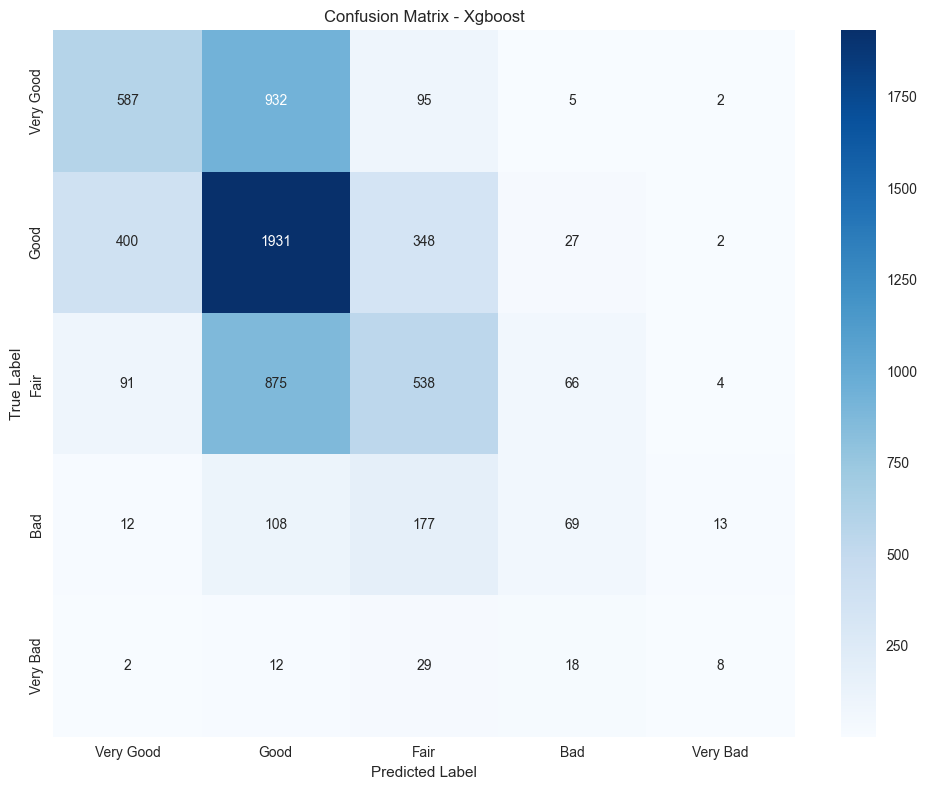


📈 PREDICTION BREAKDOWN:
  Correct predictions: 3,133 (49.3%)
  Incorrect predictions: 3,218 (50.7%)
✓ Saved detailed analysis to /Users/peter/Desktop/health_xai_prediction/results/error_analysis


In [5]:
# ============================================================================
# 1. COMPREHENSIVE MODEL PREDICTIONS AND EVALUATION
# ============================================================================

print("🔍 1. COMPREHENSIVE MODEL PREDICTIONS AND EVALUATION")
print("=" * 60)

# Get predictions from all models
all_predictions = {}
all_probabilities = {}

for model_name, model in models.items():
    print(f"\nObtaining predictions for {model_name}...")
    
    if model_name == 'neural_network':
        # Handle neural network predictions
        with torch.no_grad():
            X_test_tensor = torch.FloatTensor(X_test.values)
            logits = model(X_test_tensor)
            probabilities = F.softmax(logits, dim=1).numpy()
            predictions = np.argmax(probabilities, axis=1) + 1  # Convert back to 1-5 scale
    else:
        # Handle sklearn models
        predictions = model.predict(X_test)
        if hasattr(model, 'predict_proba'):
            probabilities = model.predict_proba(X_test)
        else:
            # For SVM without probability
            probabilities = None
    
    all_predictions[model_name] = predictions
    all_probabilities[model_name] = probabilities

# Calculate confusion matrices and metrics
confusion_matrices = {}
classification_reports = {}

for model_name, predictions in all_predictions.items():
    # Confusion matrix
    cm = confusion_matrix(y_test, predictions)
    confusion_matrices[model_name] = cm
    
    # Classification report
    report = classification_report(y_test, predictions, 
                                 target_names=class_names,
                                 output_dict=True)
    classification_reports[model_name] = report
    
    # Display metrics
    accuracy = accuracy_score(y_test, predictions)
    print(f"\n📊 {model_name.upper()} PERFORMANCE:")
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  Macro F1: {report['macro avg']['f1-score']:.3f}")
    print(f"  Weighted F1: {report['weighted avg']['f1-score']:.3f}")

# Identify best performing model
best_model_name = max(all_predictions.keys(), 
                     key=lambda m: classification_reports[m]['accuracy'])
best_predictions = all_predictions[best_model_name]
best_probabilities = all_probabilities[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name} (Accuracy: {classification_reports[best_model_name]['accuracy']:.3f})")

# Visualize confusion matrix for best model
plt.figure(figsize=(10, 8))
cm = confusion_matrices[best_model_name]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_model_name.replace("_", " ").title()}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(ERROR_ANALYSIS_DIR / f'confusion_matrix_{best_model_name}.png', dpi=300, bbox_inches='tight')
plt.show()

# Create detailed error analysis DataFrame
error_analysis_df = []
for i, (true_label, pred_label) in enumerate(zip(y_test, best_predictions)):
    row_data = {
        'sample_idx': y_test.index[i],
        'true_class': true_label,
        'true_class_name': class_names[true_label-1],
        'predicted_class': pred_label,
        'predicted_class_name': class_names[pred_label-1],
        'correct': true_label == pred_label,
        'model': best_model_name
    }
    
    # Add probability information if available
    if best_probabilities is not None:
        row_data['max_probability'] = np.max(best_probabilities[i])
        row_data['predicted_probability'] = best_probabilities[i][pred_label-1]
        row_data['true_class_probability'] = best_probabilities[i][true_label-1]
        
    # Add feature values
    for feature_name in feature_names:
        row_data[feature_name] = X_test.iloc[i][feature_name]
    
    error_analysis_df.append(row_data)

error_analysis_df = pd.DataFrame(error_analysis_df)

# Separate correct and incorrect predictions
correct_predictions = error_analysis_df[error_analysis_df['correct'] == True]
incorrect_predictions = error_analysis_df[error_analysis_df['correct'] == False]

print(f"\n📈 PREDICTION BREAKDOWN:")
print(f"  Correct predictions: {len(correct_predictions):,} ({len(correct_predictions)/len(error_analysis_df)*100:.1f}%)")
print(f"  Incorrect predictions: {len(incorrect_predictions):,} ({len(incorrect_predictions)/len(error_analysis_df)*100:.1f}%)")

# Save error analysis data
error_analysis_df.to_csv(ERROR_ANALYSIS_DIR / 'detailed_predictions.csv', index=False)
incorrect_predictions.to_csv(ERROR_ANALYSIS_DIR / 'misclassified_samples.csv', index=False)

print(f"✓ Saved detailed analysis to {ERROR_ANALYSIS_DIR}")

🔍 2. ANALYZING ERROR PATTERNS AND MISCLASSIFICATIONS
Analyzing 3218 misclassified samples...

📊 ERROR DIRECTION ANALYSIS:
Error types:
  • Under-predicted (1 levels): 1470 cases (45.7%)
  • Over-predicted (1 levels): 1359 cases (42.2%)
  • Under-predicted (2 levels): 228 cases (7.1%)
  • Over-predicted (2 levels): 126 cases (3.9%)
  • Under-predicted (3 levels): 24 cases (0.7%)
  • Over-predicted (3 levels): 7 cases (0.2%)
  • Over-predicted (4 levels): 2 cases (0.1%)
  • Under-predicted (4 levels): 2 cases (0.1%)

📋 CLASS-SPECIFIC ERROR ANALYSIS:
Per-class performance:
  🏷️ Very Good:
     Accuracy: 0.362 (587/1621 samples)
     Most confused with: Good (932 cases)
  🏷️ Good:
     Accuracy: 0.713 (1931/2708 samples)
     Most confused with: Very Good (400 cases)
  🏷️ Fair:
     Accuracy: 0.342 (538/1574 samples)
     Most confused with: Good (875 cases)
  🏷️ Bad:
     Accuracy: 0.182 (69/379 samples)
     Most confused with: Fair (177 cases)
  🏷️ Very Bad:
     Accuracy: 0.116 (8/69 s

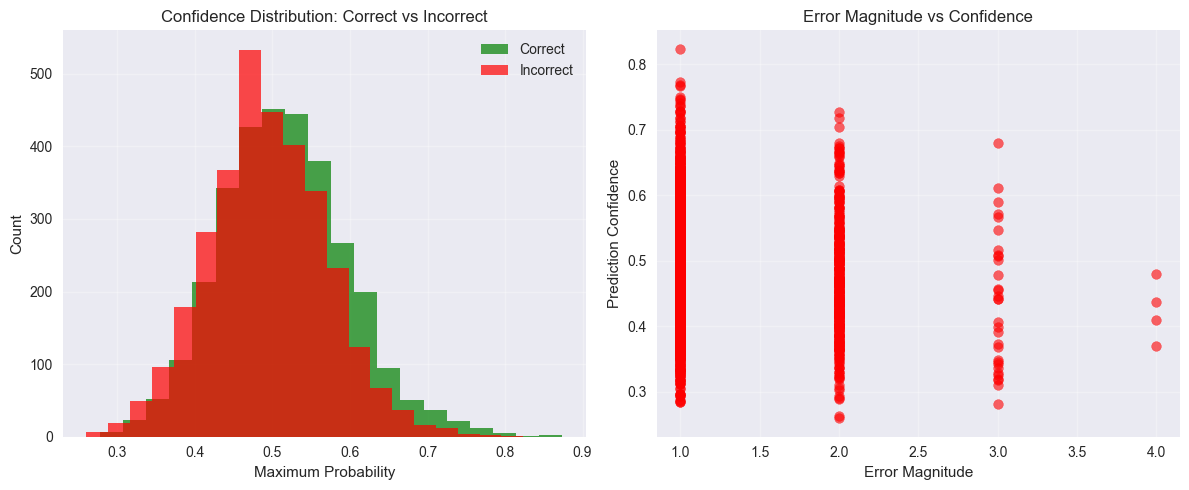


✓ Error pattern analysis complete. Found 3218 errors to investigate further.


In [6]:
# ============================================================================
# 2. ERROR PATTERN ANALYSIS
# ============================================================================

print("🔍 2. ANALYZING ERROR PATTERNS AND MISCLASSIFICATIONS")
print("=" * 60)

if len(incorrect_predictions) == 0:
    print("✨ Perfect predictions! No errors to analyze.")
else:
    print(f"Analyzing {len(incorrect_predictions)} misclassified samples...")

    # 2.1 Error Direction Analysis
    print(f"\n📊 ERROR DIRECTION ANALYSIS:")
    
    # Calculate error magnitude (how far off predictions are)
    incorrect_predictions['error_magnitude'] = abs(
        incorrect_predictions['true_class'] - incorrect_predictions['predicted_class']
    )
    incorrect_predictions['error_direction'] = (
        incorrect_predictions['predicted_class'] - incorrect_predictions['true_class']
    )
    
    # Categorize errors
    def categorize_error(row):
        if row['error_direction'] > 0:
            return f"Over-predicted ({row['error_magnitude']} levels)"
        else:
            return f"Under-predicted ({row['error_magnitude']} levels)"
    
    incorrect_predictions['error_type'] = incorrect_predictions.apply(categorize_error, axis=1)
    
    error_type_counts = incorrect_predictions['error_type'].value_counts()
    print("Error types:")
    for error_type, count in error_type_counts.items():
        pct = count / len(incorrect_predictions) * 100
        print(f"  • {error_type}: {count} cases ({pct:.1f}%)")
    
    # 2.2 Class-Specific Error Analysis
    print(f"\n📋 CLASS-SPECIFIC ERROR ANALYSIS:")
    
    # Create confusion analysis
    confusion_analysis = []
    cm = confusion_matrices[best_model_name]
    
    for i, true_class_name in enumerate(class_names):
        true_class = i + 1
        true_class_samples = len(y_test[y_test == true_class])
        correct_predictions_class = cm[i, i]
        
        if true_class_samples > 0:
            class_accuracy = correct_predictions_class / true_class_samples
            
            # Find most common misclassifications for this class
            class_errors = incorrect_predictions[incorrect_predictions['true_class'] == true_class]
            
            if len(class_errors) > 0:
                most_common_error = class_errors['predicted_class_name'].mode().iloc[0]
                error_count = len(class_errors[class_errors['predicted_class_name'] == most_common_error])
            else:
                most_common_error = "None"
                error_count = 0
            
            confusion_analysis.append({
                'true_class': true_class_name,
                'samples': true_class_samples,
                'correct': correct_predictions_class,
                'accuracy': class_accuracy,
                'errors': len(class_errors),
                'most_common_error': most_common_error,
                'error_count': error_count
            })
    
    confusion_df = pd.DataFrame(confusion_analysis)
    print("Per-class performance:")
    for _, row in confusion_df.iterrows():
        print(f"  🏷️ {row['true_class']}:")
        print(f"     Accuracy: {row['accuracy']:.3f} ({row['correct']}/{row['samples']} samples)")
        if row['errors'] > 0:
            print(f"     Most confused with: {row['most_common_error']} ({row['error_count']} cases)")
    
    # 2.3 Adjacent vs. Distant Errors
    print(f"\n📏 ERROR SEVERITY ANALYSIS:")
    
    # Adjacent errors (off by 1 class) vs distant errors (off by 2+ classes)
    adjacent_errors = incorrect_predictions[incorrect_predictions['error_magnitude'] == 1]
    distant_errors = incorrect_predictions[incorrect_predictions['error_magnitude'] >= 2]
    
    print(f"Adjacent errors (off by 1 class): {len(adjacent_errors)} ({len(adjacent_errors)/len(incorrect_predictions)*100:.1f}%)")
    print(f"Distant errors (off by 2+ classes): {len(distant_errors)} ({len(distant_errors)/len(incorrect_predictions)*100:.1f}%)")
    
    if len(distant_errors) > 0:
        print(f"⚠️ Severe misclassifications detected:")
        severe_errors = distant_errors.nlargest(3, 'error_magnitude')[['true_class_name', 'predicted_class_name', 'error_magnitude']]
        for _, row in severe_errors.iterrows():
            print(f"  • {row['true_class_name']} → {row['predicted_class_name']} (off by {row['error_magnitude']})")
    
    # 2.4 Confidence Analysis for Errors
    if best_probabilities is not None:
        print(f"\n🎯 CONFIDENCE ANALYSIS FOR ERRORS:")
        
        # Calculate confidence metrics
        high_conf_errors = incorrect_predictions[incorrect_predictions['max_probability'] > 0.7]
        low_conf_errors = incorrect_predictions[incorrect_predictions['max_probability'] <= 0.5]
        
        print(f"High-confidence errors (>0.7): {len(high_conf_errors)} ({len(high_conf_errors)/len(incorrect_predictions)*100:.1f}%)")
        print(f"Low-confidence errors (≤0.5): {len(low_conf_errors)} ({len(low_conf_errors)/len(incorrect_predictions)*100:.1f}%)")
        
        if len(high_conf_errors) > 0:
            print("⚠️ High-confidence errors are concerning - model is confidently wrong!")
            avg_conf = high_conf_errors['max_probability'].mean()
            print(f"   Average confidence for wrong predictions: {avg_conf:.3f}")
        
        # Visualize confidence distribution
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.hist(correct_predictions['max_probability'], bins=20, alpha=0.7, label='Correct', color='green')
        plt.hist(incorrect_predictions['max_probability'], bins=20, alpha=0.7, label='Incorrect', color='red')
        plt.xlabel('Maximum Probability')
        plt.ylabel('Count')
        plt.title('Confidence Distribution: Correct vs Incorrect')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.scatter(incorrect_predictions['error_magnitude'], 
                   incorrect_predictions['max_probability'], 
                   alpha=0.6, color='red')
        plt.xlabel('Error Magnitude')
        plt.ylabel('Prediction Confidence')
        plt.title('Error Magnitude vs Confidence')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(ERROR_ANALYSIS_DIR / 'confidence_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    print(f"\n✓ Error pattern analysis complete. Found {len(incorrect_predictions)} errors to investigate further.")

🔍 3. ANALYZING FEATURE IMPORTANCE AND ERROR CORRELATIONS

📊 FEATURE IMPORTANCE ANALYSIS:

🎯 FEATURE VALUE ANALYSIS FOR MISCLASSIFIED SAMPLES:
Features with significantly different values in misclassified samples:
  1. fltsd:
     Misclassified samples have higher values
     Correct: -0.077, Incorrect: 0.056
     Difference: 172.3%, p-value: 0.0000
  2. flteeff:
     Misclassified samples have higher values
     Correct: -0.068, Incorrect: 0.059
     Difference: 187.9%, p-value: 0.0000
  3. fltlnl:
     Misclassified samples have higher values
     Correct: -0.054, Incorrect: 0.077
     Difference: 243.1%, p-value: 0.0000
  4. wrhpp:
     Misclassified samples have lower values
     Correct: 0.053, Incorrect: -0.058
     Difference: 209.6%, p-value: 0.0000
  5. inprdsc:
     Misclassified samples have lower values
     Correct: 0.083, Incorrect: -0.011
     Difference: 113.5%, p-value: 0.0001

📈 VISUALIZING FEATURE DISTRIBUTIONS:


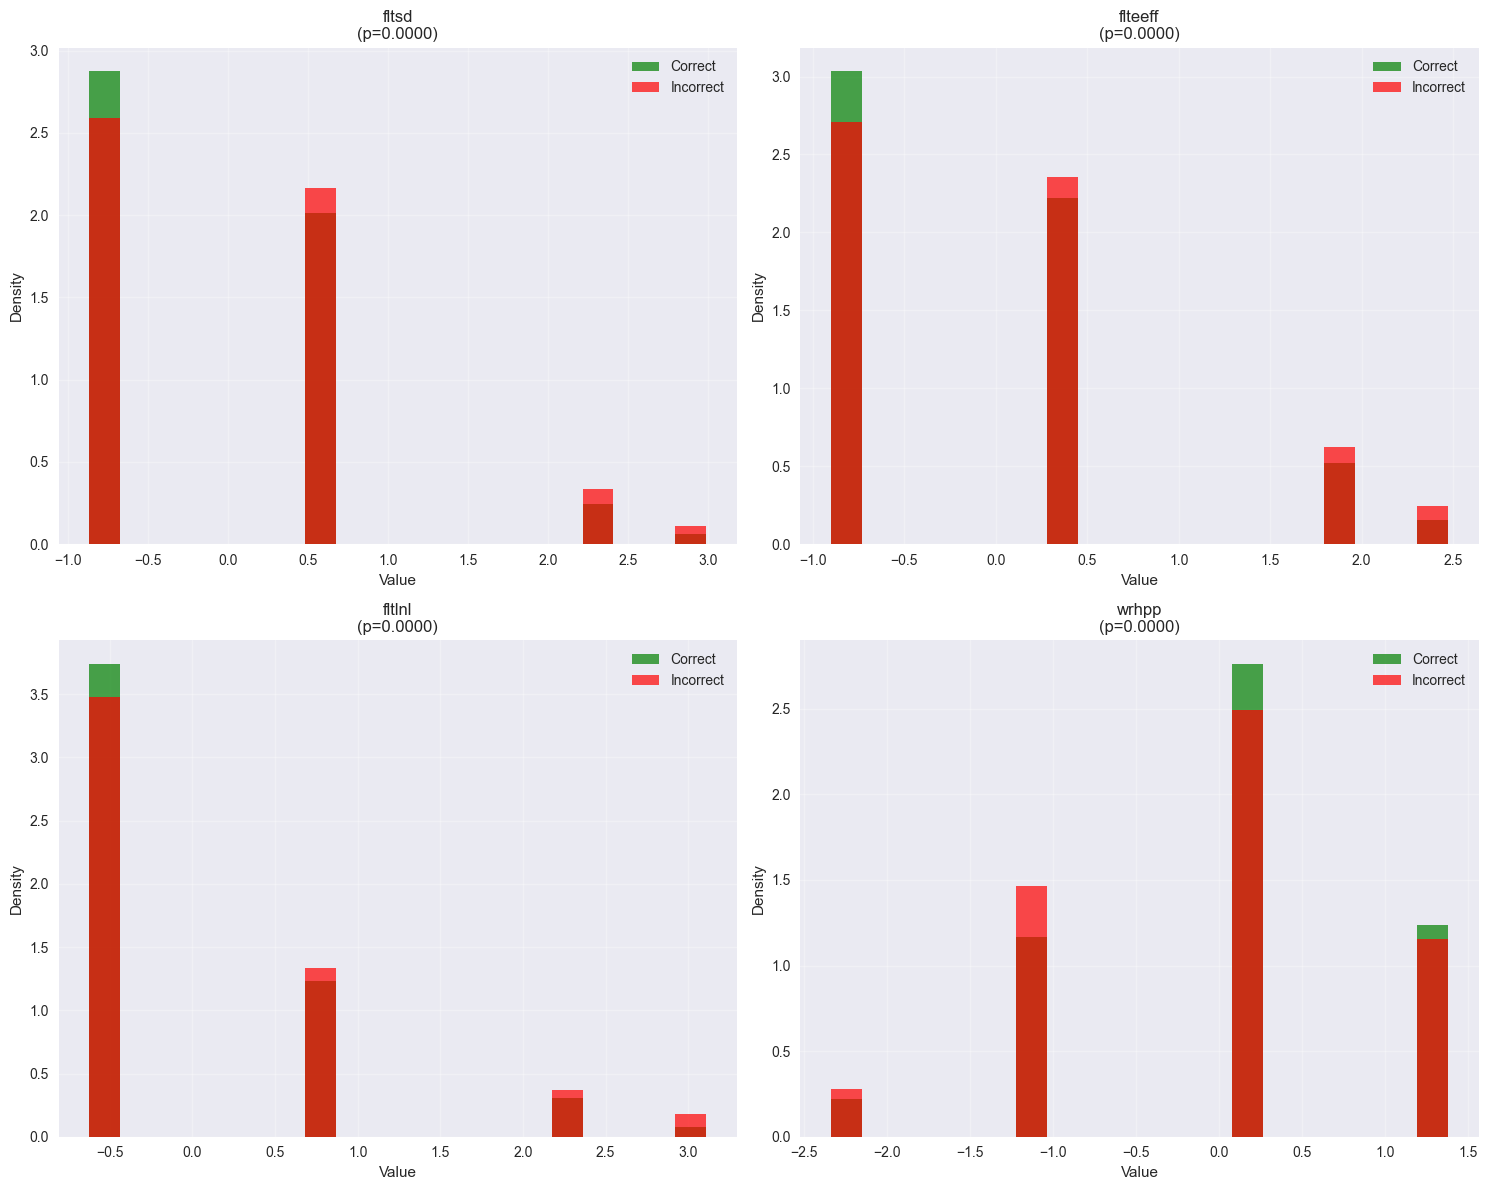


🔗 CORRELATION ANALYSIS:
Features most correlated with prediction errors:
  1. fltsd: +0.0662 (positively correlated)
  2. fltlnl: +0.0648 (positively correlated)
  3. flteeff: +0.0638 (positively correlated)
  4. wrhpp: -0.0564 (negatively correlated)
  5. happy: -0.0551 (negatively correlated)

✓ Feature analysis complete. Identified key patterns in misclassified samples.


In [7]:
# ============================================================================
# 3. FEATURE IMPORTANCE AND ERROR CORRELATION ANALYSIS
# ============================================================================

print("🔍 3. ANALYZING FEATURE IMPORTANCE AND ERROR CORRELATIONS")
print("=" * 60)

# 3.1 Feature Importance Analysis
print(f"\n📊 FEATURE IMPORTANCE ANALYSIS:")

# Get feature importance from tree-based models
feature_importance_data = {}

for model_name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        # Tree-based models (Random Forest, XGBoost)
        importances = model.feature_importances_
        feature_importance_data[model_name] = dict(zip(feature_names, importances))
    elif hasattr(model, 'coef_'):
        # Linear models (Logistic Regression, SVM)
        # Use average absolute coefficient across all classes
        if len(model.coef_.shape) > 1:
            # Multi-class
            importances = np.mean(np.abs(model.coef_), axis=0)
        else:
            importances = np.abs(model.coef_[0])
        feature_importance_data[model_name] = dict(zip(feature_names, importances))

# Display top features for best model
if best_model_name in feature_importance_data:
    best_model_importance = feature_importance_data[best_model_name]
    top_features = sorted(best_model_importance.items(), key=lambda x: x[1], reverse=True)[:10]
    
    print(f"Top 10 most important features ({best_model_name}):")
    for i, (feature, importance) in enumerate(top_features, 1):
        print(f"  {i:2d}. {feature}: {importance:.4f}")

# 3.2 Feature Value Analysis for Errors
print(f"\n🎯 FEATURE VALUE ANALYSIS FOR MISCLASSIFIED SAMPLES:")

if len(incorrect_predictions) > 0:
    # Analyze feature distributions for correct vs incorrect predictions
    significant_features = []
    
    for feature in feature_names:
        if feature in incorrect_predictions.columns:
            # Get values for correct and incorrect predictions
            correct_values = correct_predictions[feature].dropna()
            incorrect_values = incorrect_predictions[feature].dropna()
            
            if len(correct_values) > 0 and len(incorrect_values) > 0:
                # Statistical test
                try:
                    # Use Mann-Whitney U test (non-parametric)
                    from scipy.stats import mannwhitneyu
                    stat, p_value = mannwhitneyu(correct_values, incorrect_values, 
                                               alternative='two-sided')
                    
                    if p_value < 0.05:  # Significant difference
                        mean_correct = correct_values.mean()
                        mean_incorrect = incorrect_values.mean()
                        diff_pct = abs(mean_incorrect - mean_correct) / abs(mean_correct) * 100
                        
                        significant_features.append({
                            'feature': feature,
                            'p_value': p_value,
                            'mean_correct': mean_correct,
                            'mean_incorrect': mean_incorrect,
                            'difference_pct': diff_pct,
                            'direction': 'higher' if mean_incorrect > mean_correct else 'lower'
                        })
                except:
                    pass
    
    # Sort by significance and display
    significant_features.sort(key=lambda x: x['p_value'])
    
    if significant_features:
        print("Features with significantly different values in misclassified samples:")
        for i, feat in enumerate(significant_features[:5], 1):  # Top 5
            print(f"  {i}. {feat['feature']}:")
            print(f"     Misclassified samples have {feat['direction']} values")
            print(f"     Correct: {feat['mean_correct']:.3f}, Incorrect: {feat['mean_incorrect']:.3f}")
            print(f"     Difference: {feat['difference_pct']:.1f}%, p-value: {feat['p_value']:.4f}")
    else:
        print("No statistically significant feature differences found")

# 3.3 Visualize Feature Distributions
if len(significant_features) > 0:
    print(f"\n📈 VISUALIZING FEATURE DISTRIBUTIONS:")
    
    # Plot top 4 most significant features
    top_4_features = significant_features[:4]
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, feat_info in enumerate(top_4_features):
        feature = feat_info['feature']
        
        if feature in correct_predictions.columns and feature in incorrect_predictions.columns:
            ax = axes[i]
            
            # Plot distributions
            correct_values = correct_predictions[feature].dropna()
            incorrect_values = incorrect_predictions[feature].dropna()
            
            ax.hist(correct_values, bins=20, alpha=0.7, label='Correct', color='green', density=True)
            ax.hist(incorrect_values, bins=20, alpha=0.7, label='Incorrect', color='red', density=True)
            
            ax.set_title(f'{feature}\n(p={feat_info["p_value"]:.4f})')
            ax.set_xlabel('Value')
            ax.set_ylabel('Density')
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    # Remove empty subplots
    for j in range(len(top_4_features), 4):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig(ERROR_ANALYSIS_DIR / 'feature_distributions_errors.png', dpi=300, bbox_inches='tight')
    plt.show()

# 3.4 Correlation Analysis
print(f"\n🔗 CORRELATION ANALYSIS:")

# Calculate correlation between features and error occurrence
if len(incorrect_predictions) > 0:
    # Create error indicator
    error_analysis_df['is_error'] = ~error_analysis_df['correct']
    
    # Calculate correlations
    feature_error_corr = []
    for feature in feature_names:
        if feature in error_analysis_df.columns:
            try:
                corr = error_analysis_df[feature].corr(error_analysis_df['is_error'])
                if not pd.isna(corr):
                    feature_error_corr.append({
                        'feature': feature,
                        'correlation': corr,
                        'abs_correlation': abs(corr)
                    })
            except:
                pass
    
    # Sort by absolute correlation
    feature_error_corr.sort(key=lambda x: x['abs_correlation'], reverse=True)
    
    if feature_error_corr:
        print("Features most correlated with prediction errors:")
        for i, feat in enumerate(feature_error_corr[:5], 1):
            direction = "positively" if feat['correlation'] > 0 else "negatively"
            print(f"  {i}. {feat['feature']}: {feat['correlation']:+.4f} ({direction} correlated)")

print(f"\n✓ Feature analysis complete. Identified key patterns in misclassified samples.")

🔍 4. ANALYZING CLASS IMBALANCE IMPACT ON PREDICTIONS

📊 CLASS DISTRIBUTION ANALYSIS:
Test set class distribution:
  1 (Very Good): 1,621 samples (25.5%) - ratio 1:1.7
  2 (Good): 2,708 samples (42.6%) - ratio 1:1.0
  3 (Fair): 1,574 samples (24.8%) - ratio 1:1.7
  4 (Bad): 379 samples (6.0%) - ratio 1:7.1
  5 (Very Bad): 69 samples (1.1%) - ratio 1:39.2

Maximum imbalance ratio: 1:39.2

📈 PERFORMANCE VS CLASS SIZE:
Performance by class size:
  Very Good (n=1621):
    Precision: 0.000, Recall: 0.000, F1: 0.000
    Imbalance ratio: 1:1.7
  Good (n=2708):
    Precision: 0.000, Recall: 0.000, F1: 0.000
    Imbalance ratio: 1:1.0
  Fair (n=1574):
    Precision: 0.000, Recall: 0.000, F1: 0.000
    Imbalance ratio: 1:1.7
  Bad (n=379):
    Precision: 0.000, Recall: 0.000, F1: 0.000
    Imbalance ratio: 1:7.1
  Very Bad (n=69):
    Precision: 0.000, Recall: 0.000, F1: 0.000
    Imbalance ratio: 1:39.2

🎯 MINORITY CLASS PERFORMANCE:
Minority classes (smallest 2):
  • Very Bad: 69 samples
    ⚠️

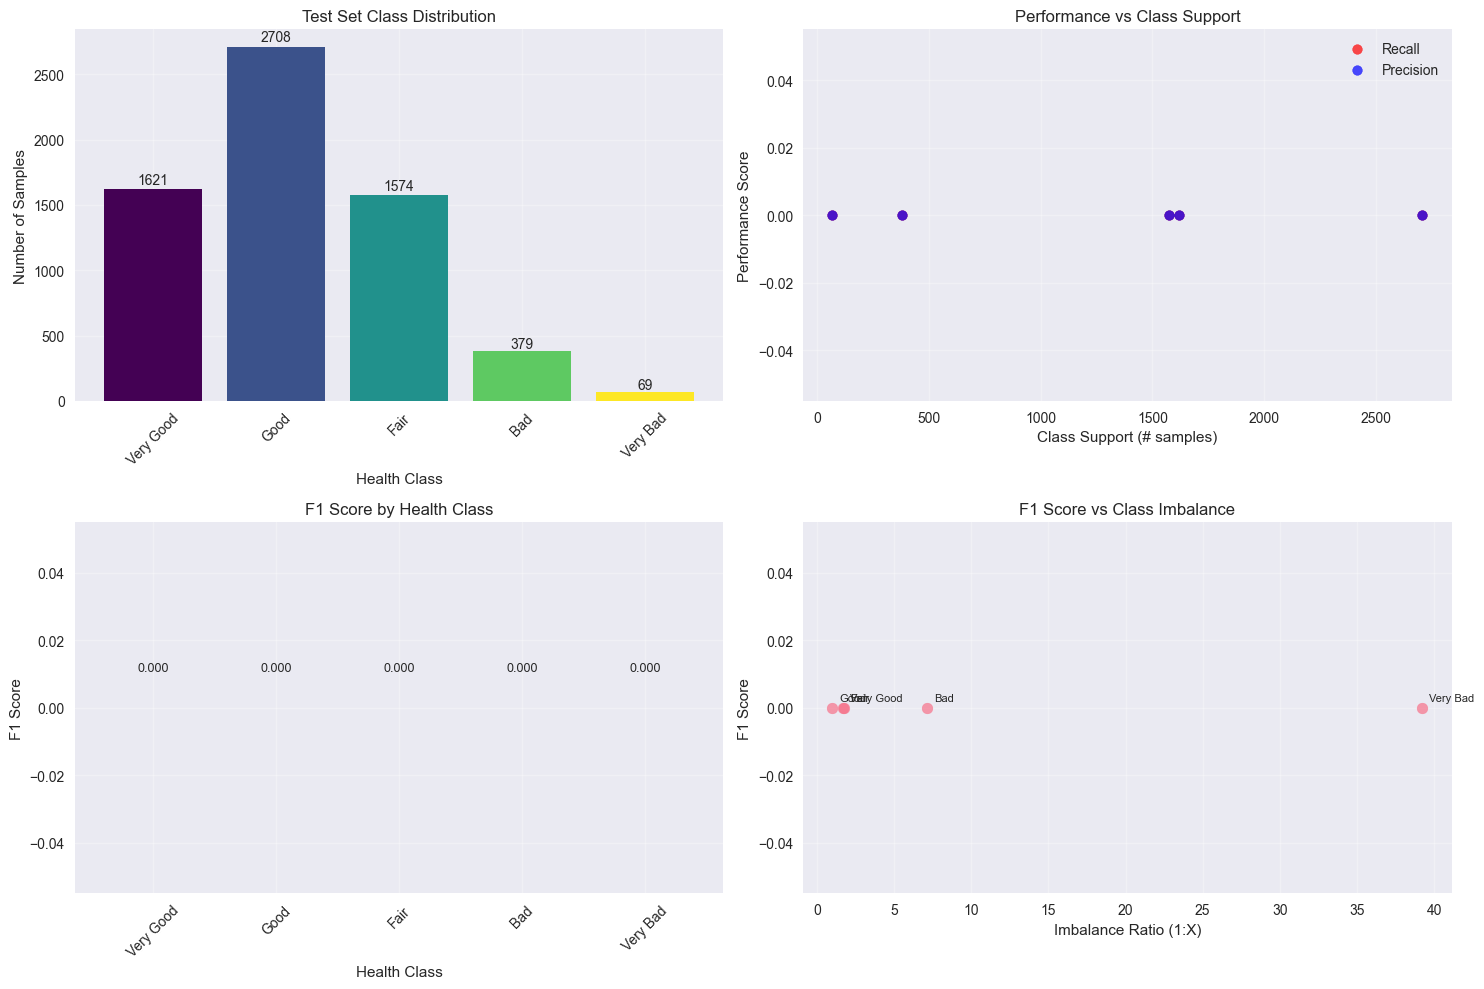


🔍 CONFUSION PATTERNS FOR MINORITY CLASSES:
  Very Bad (n=69):
    Most often confused with: Fair (29 cases)
    False negative rate: 0.884
  Bad (n=379):
    Most often confused with: Fair (177 cases)
    False negative rate: 0.818

💡 RECOMMENDATIONS FOR CLASS IMBALANCE:
🚨 Severe class imbalance detected (>5:1 ratio)
Recommended strategies:
  • SMOTE or ADASYN for synthetic minority oversampling
  • Class weights in model training
  • Ensemble methods with balanced sampling
  • Threshold optimization for minority classes

⚖️ Suggested class weights for balanced training:
  Class Very Good: 0.78
  Class Good: 0.47
  Class Fair: 0.81
  Class Bad: 3.35
  Class Very Bad: 18.41

✓ Class imbalance analysis complete.


In [8]:
# ============================================================================
# 4. CLASS IMBALANCE IMPACT ANALYSIS
# ============================================================================

print("🔍 4. ANALYZING CLASS IMBALANCE IMPACT ON PREDICTIONS")
print("=" * 60)

# 4.1 Class Distribution Analysis
print(f"\n📊 CLASS DISTRIBUTION ANALYSIS:")

# Calculate class frequencies and imbalance ratios
class_counts = pd.Series(y_test).value_counts().sort_index()
total_samples = len(y_test)

print("Test set class distribution:")
imbalance_ratios = {}
max_class_count = class_counts.max()

for class_idx, count in class_counts.items():
    pct = count / total_samples * 100
    ratio = max_class_count / count
    imbalance_ratios[class_idx] = ratio
    print(f"  {class_idx} ({class_names[class_idx-1]}): {count:,} samples ({pct:.1f}%) - ratio 1:{ratio:.1f}")

max_imbalance_ratio = max(imbalance_ratios.values())
print(f"\nMaximum imbalance ratio: 1:{max_imbalance_ratio:.1f}")

# 4.2 Performance vs Class Size Analysis
print(f"\n📈 PERFORMANCE VS CLASS SIZE:")

perf_vs_size = []
for class_idx in sorted(class_counts.index):
    class_name = class_names[class_idx-1]
    
    # Get metrics for this class from classification report
    if str(class_idx) in classification_reports[best_model_name]:
        metrics = classification_reports[best_model_name][str(class_idx)]
        precision = metrics['precision']
        recall = metrics['recall'] 
        f1 = metrics['f1-score']
    else:
        precision = recall = f1 = 0.0
    
    support = class_counts[class_idx]
    
    perf_vs_size.append({
        'class_idx': class_idx,
        'class_name': class_name,
        'support': support,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'imbalance_ratio': imbalance_ratios[class_idx]
    })

perf_df = pd.DataFrame(perf_vs_size)

print("Performance by class size:")
for _, row in perf_df.iterrows():
    print(f"  {row['class_name']} (n={row['support']}):")
    print(f"    Precision: {row['precision']:.3f}, Recall: {row['recall']:.3f}, F1: {row['f1_score']:.3f}")
    print(f"    Imbalance ratio: 1:{row['imbalance_ratio']:.1f}")

# 4.3 Minority Class Analysis
print(f"\n🎯 MINORITY CLASS PERFORMANCE:")

# Identify minority classes (bottom 40% by sample count)
sorted_classes = perf_df.sort_values('support')
num_minority = max(1, int(len(sorted_classes) * 0.4))
minority_classes = sorted_classes.head(num_minority)

print(f"Minority classes (smallest {num_minority}):")
for _, row in minority_classes.iterrows():
    print(f"  • {row['class_name']}: {row['support']} samples")
    if row['recall'] < 0.5:
        print(f"    ⚠️ Poor recall: {row['recall']:.3f}")
    if row['precision'] < 0.5:
        print(f"    ⚠️ Poor precision: {row['precision']:.3f}")

# 4.4 Visualize Class Imbalance Impact
plt.figure(figsize=(15, 10))

# Plot 1: Class distribution
plt.subplot(2, 2, 1)
bars = plt.bar(range(len(class_counts)), class_counts.values, 
               color=plt.cm.viridis(np.linspace(0, 1, len(class_counts))))
plt.xlabel('Health Class')
plt.ylabel('Number of Samples')
plt.title('Test Set Class Distribution')
plt.xticks(range(len(class_counts)), [class_names[i-1] for i in class_counts.index], rotation=45)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{height}', ha='center', va='bottom', fontsize=10)
plt.grid(True, alpha=0.3)

# Plot 2: Performance vs Support
plt.subplot(2, 2, 2)
plt.scatter(perf_df['support'], perf_df['recall'], alpha=0.7, color='red', label='Recall')
plt.scatter(perf_df['support'], perf_df['precision'], alpha=0.7, color='blue', label='Precision')
plt.xlabel('Class Support (# samples)')
plt.ylabel('Performance Score')
plt.title('Performance vs Class Support')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: F1 Score by Class
plt.subplot(2, 2, 3)
bars = plt.bar(range(len(perf_df)), perf_df['f1_score'], 
               color=plt.cm.RdYlBu(perf_df['f1_score']))
plt.xlabel('Health Class')
plt.ylabel('F1 Score')
plt.title('F1 Score by Health Class')
plt.xticks(range(len(perf_df)), [row['class_name'] for _, row in perf_df.iterrows()], rotation=45)
plt.grid(True, alpha=0.3)
for i, (_, row) in enumerate(perf_df.iterrows()):
    plt.text(i, row['f1_score'] + 0.01, f'{row["f1_score"]:.3f}', 
             ha='center', va='bottom', fontsize=9)

# Plot 4: Imbalance ratio effect
plt.subplot(2, 2, 4)
plt.scatter(perf_df['imbalance_ratio'], perf_df['f1_score'], alpha=0.7, s=60)
for _, row in perf_df.iterrows():
    plt.annotate(row['class_name'], 
                (row['imbalance_ratio'], row['f1_score']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)
plt.xlabel('Imbalance Ratio (1:X)')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Class Imbalance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(ERROR_ANALYSIS_DIR / 'class_imbalance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 4.5 Confusion Matrix Analysis by Class Size
print(f"\n🔍 CONFUSION PATTERNS FOR MINORITY CLASSES:")

cm = confusion_matrices[best_model_name]
for _, minority_class in minority_classes.iterrows():
    class_idx = minority_class['class_idx'] - 1  # Convert to 0-indexed
    class_name = minority_class['class_name']
    
    # Analyze confusion for this class
    true_positives = cm[class_idx, class_idx]
    false_negatives = cm[class_idx, :].sum() - true_positives
    false_positives = cm[:, class_idx].sum() - true_positives
    
    if false_negatives > 0:
        # Find where this class is most often misclassified
        misclassified_as = np.argmax(cm[class_idx, :][np.arange(len(cm)) != class_idx])
        if misclassified_as >= class_idx:
            misclassified_as += 1  # Adjust for skipped diagonal
        misclassified_count = cm[class_idx, misclassified_as]
        misclassified_name = class_names[misclassified_as]
        
        print(f"  {class_name} (n={minority_class['support']}):")
        print(f"    Most often confused with: {misclassified_name} ({misclassified_count} cases)")
        print(f"    False negative rate: {false_negatives/minority_class['support']:.3f}")

# 4.6 Recommendations for Imbalance
print(f"\n💡 RECOMMENDATIONS FOR CLASS IMBALANCE:")

if max_imbalance_ratio > 5:
    print("🚨 Severe class imbalance detected (>5:1 ratio)")
    print("Recommended strategies:")
    print("  • SMOTE or ADASYN for synthetic minority oversampling")
    print("  • Class weights in model training")
    print("  • Ensemble methods with balanced sampling")
    print("  • Threshold optimization for minority classes")
    
    # Calculate suggested class weights
    n_samples = len(y_test)
    n_classes = len(class_counts)
    
    print(f"\n⚖️ Suggested class weights for balanced training:")
    for class_idx, count in class_counts.items():
        weight = n_samples / (n_classes * count)
        print(f"  Class {class_names[class_idx-1]}: {weight:.2f}")

elif max_imbalance_ratio > 2:
    print("⚠️ Moderate class imbalance detected (2-5:1 ratio)")
    print("Recommended strategies:")
    print("  • Class weights in model training")
    print("  • Stratified sampling")
    print("  • Threshold optimization")
else:
    print("✅ Class distribution is reasonably balanced")
    print("Consider:")
    print("  • Standard cross-validation")
    print("  • Focus on overall model performance")

print(f"\n✓ Class imbalance analysis complete.")

🔍 5. ANALYZING DECISION BOUNDARIES AND PROBABILITY CALIBRATION

🎯 PROBABILITY CALIBRATION ANALYSIS:
  Very Good: ECE = 0.010
  Good: ECE = 0.009
  Fair: ECE = 0.011
  Bad: ECE = 0.008
  Very Bad: ECE = 0.004


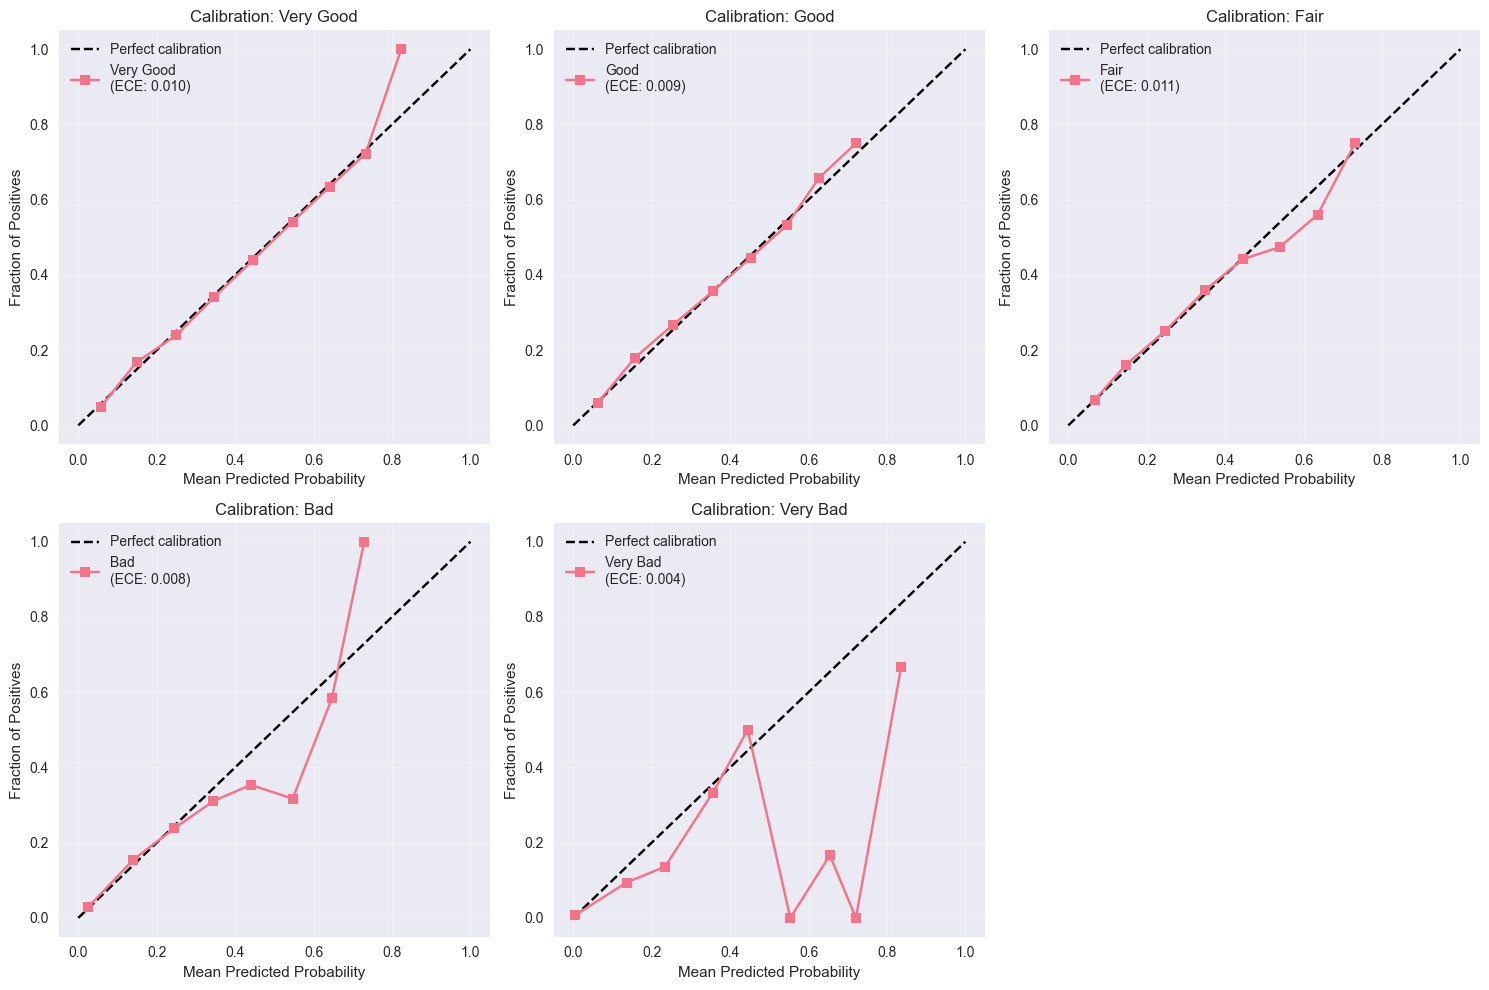


Average Expected Calibration Error: 0.009
✅ Good calibration - probabilities are reliable

📊 CONFIDENCE vs ACCURACY ANALYSIS:
Accuracy by confidence level:
  0.0-0.5: 0.436 accuracy (3149 samples)
  0.5-0.6: 0.522 accuracy (2489 samples)
  0.6-0.7: 0.633 accuracy (618 samples)
  0.7-0.8: 0.716 accuracy (88 samples)
  0.8-0.9: 0.857 accuracy (7 samples)


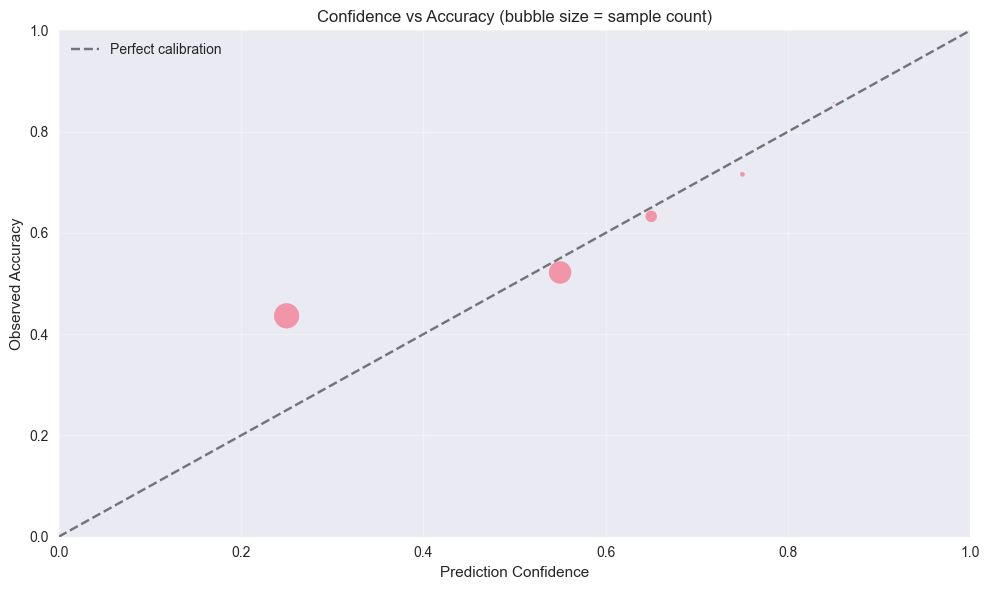


📈 CLASS PROBABILITY DISTRIBUTION ANALYSIS:


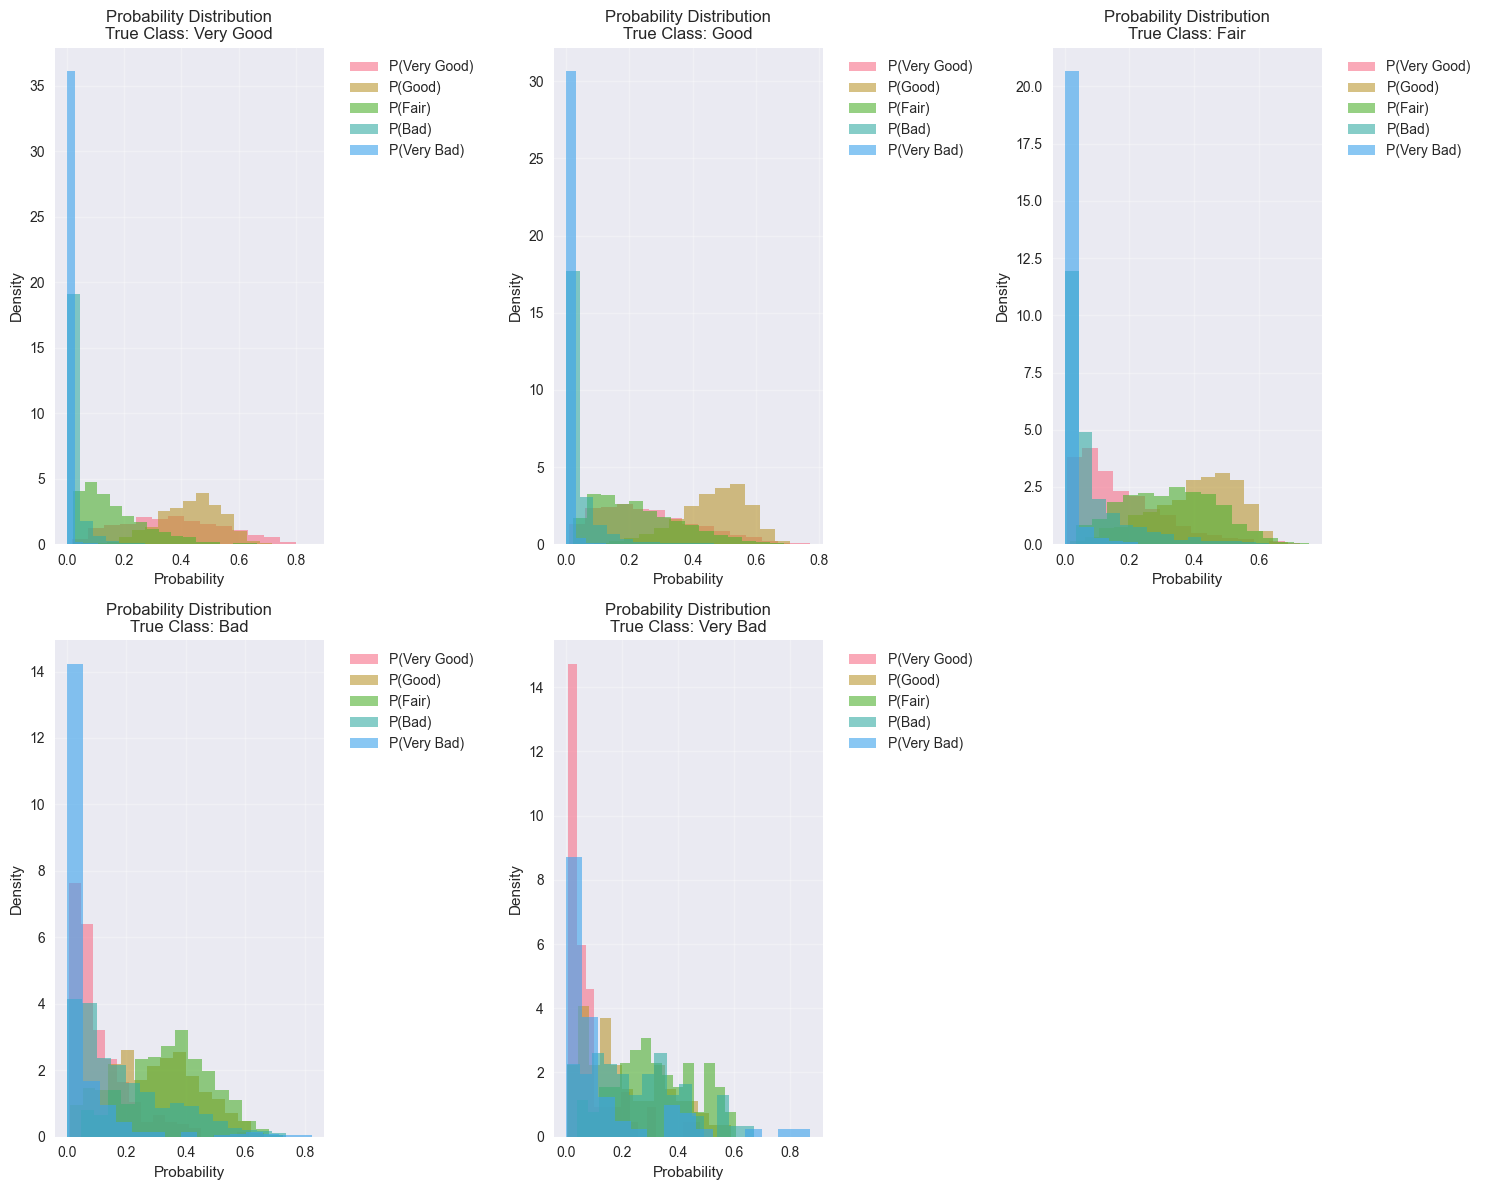


Found 3700 uncertain predictions (multiple classes >30% probability)
Most uncertain cases:


TypeError: list indices must be integers or slices, not numpy.float64

In [ ]:
# ============================================================================
# 5. DECISION BOUNDARY AND CALIBRATION ANALYSIS
# ============================================================================

print("🔍 5. ANALYZING DECISION BOUNDARIES AND PROBABILITY CALIBRATION")
print("=" * 60)

# 5.1 Probability Calibration Analysis
if best_probabilities is not None:
    print(f"\n🎯 PROBABILITY CALIBRATION ANALYSIS:")
    
    # Calculate calibration metrics
    from sklearn.calibration import calibration_curve
    
    calibration_results = {}
    
    # For each class, analyze calibration
    plt.figure(figsize=(15, 10))
    
    for i, class_name in enumerate(class_names):
        class_idx = i + 1
        
        # Create binary indicators for this class
        y_binary = (y_test == class_idx).astype(int)
        
        if class_idx <= best_probabilities.shape[1]:
            prob_positive = best_probabilities[:, i]  # Probabilities for this class
            
            try:
                # Calculate calibration curve
                fraction_pos, mean_pred_prob = calibration_curve(
                    y_binary, prob_positive, n_bins=10
                )
                
                # Calculate Expected Calibration Error (ECE)
                bin_boundaries = np.linspace(0, 1, 11)
                bin_lowers = bin_boundaries[:-1]
                bin_uppers = bin_boundaries[1:]
                
                ece = 0
                for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
                    in_bin = (prob_positive > bin_lower) & (prob_positive <= bin_upper)
                    prop_in_bin = in_bin.mean()
                    
                    if prop_in_bin > 0:
                        accuracy_in_bin = y_binary[in_bin].mean()
                        avg_confidence_in_bin = prob_positive[in_bin].mean()
                        ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
                
                calibration_results[class_name] = {
                    'ece': ece,
                    'mean_pred_prob': mean_pred_prob,
                    'fraction_pos': fraction_pos
                }
                
                # Plot calibration curve
                plt.subplot(2, 3, i+1)
                plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
                plt.plot(mean_pred_prob, fraction_pos, 's-', label=f'{class_name}\n(ECE: {ece:.3f})')
                plt.xlabel('Mean Predicted Probability')
                plt.ylabel('Fraction of Positives')
                plt.title(f'Calibration: {class_name}')
                plt.legend()
                plt.grid(True, alpha=0.3)
                
                print(f"  {class_name}: ECE = {ece:.3f}")
                
            except Exception as e:
                print(f"  {class_name}: Could not calculate calibration curve ({str(e)})")
    
    plt.tight_layout()
    plt.savefig(ERROR_ANALYSIS_DIR / 'calibration_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Overall calibration assessment
    avg_ece = np.mean([result['ece'] for result in calibration_results.values()])
    print(f"\nAverage Expected Calibration Error: {avg_ece:.3f}")
    
    if avg_ece > 0.1:
        print("⚠️ Poor calibration detected - probabilities are not reliable")
        print("Recommendations:")
        print("  • Apply Platt scaling or isotonic regression")
        print("  • Use temperature scaling for neural networks")
        print("  • Consider ensemble calibration methods")
    elif avg_ece > 0.05:
        print("⚠️ Moderate calibration issues")
        print("Consider probability calibration for better uncertainty estimates")
    else:
        print("✅ Good calibration - probabilities are reliable")

# 5.2 Confidence vs Accuracy Analysis
if best_probabilities is not None:
    print(f"\n📊 CONFIDENCE vs ACCURACY ANALYSIS:")
    
    # Bin predictions by confidence level
    confidence_levels = error_analysis_df['max_probability']
    accuracy_by_confidence = []
    
    confidence_bins = [0.0, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    
    for i in range(len(confidence_bins)-1):
        bin_lower = confidence_bins[i]
        bin_upper = confidence_bins[i+1]
        
        in_bin = (confidence_levels >= bin_lower) & (confidence_levels < bin_upper)
        if i == len(confidence_bins)-2:  # Last bin includes upper bound
            in_bin = (confidence_levels >= bin_lower) & (confidence_levels <= bin_upper)
        
        bin_predictions = error_analysis_df[in_bin]
        
        if len(bin_predictions) > 0:
            bin_accuracy = bin_predictions['correct'].mean()
            bin_count = len(bin_predictions)
            accuracy_by_confidence.append({
                'confidence_range': f'{bin_lower:.1f}-{bin_upper:.1f}',
                'accuracy': bin_accuracy,
                'count': bin_count,
                'bin_center': (bin_lower + bin_upper) / 2
            })
    
    if accuracy_by_confidence:
        print("Accuracy by confidence level:")
        for result in accuracy_by_confidence:
            print(f"  {result['confidence_range']}: {result['accuracy']:.3f} accuracy ({result['count']} samples)")
        
        # Visualize confidence vs accuracy
        plt.figure(figsize=(10, 6))
        bin_centers = [r['bin_center'] for r in accuracy_by_confidence]
        accuracies = [r['accuracy'] for r in accuracy_by_confidence]
        counts = [r['count'] for r in accuracy_by_confidence]
        
        plt.scatter(bin_centers, accuracies, s=[c/10 for c in counts], alpha=0.7)
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect calibration')
        plt.xlabel('Prediction Confidence')
        plt.ylabel('Observed Accuracy')
        plt.title('Confidence vs Accuracy (bubble size = sample count)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        
        plt.tight_layout()
        plt.savefig(ERROR_ANALYSIS_DIR / 'confidence_vs_accuracy.png', dpi=300, bbox_inches='tight')
        plt.show()

# 5.3 Class Probability Distribution Analysis
if best_probabilities is not None:
    print(f"\n📈 CLASS PROBABILITY DISTRIBUTION ANALYSIS:")
    
    # Analyze probability distributions for each true class
    plt.figure(figsize=(15, 12))
    
    for i, class_name in enumerate(class_names):
        class_idx = i + 1
        
        # Get samples for this true class
        class_mask = y_test == class_idx
        class_probabilities = best_probabilities[class_mask]
        
        if len(class_probabilities) > 0:
            plt.subplot(2, 3, i+1)
            
            # Plot probability distribution for each predicted class
            for j, pred_class_name in enumerate(class_names):
                if j < class_probabilities.shape[1]:
                    probs = class_probabilities[:, j]
                    plt.hist(probs, bins=15, alpha=0.6, label=f'P({pred_class_name})',
                            density=True)
            
            plt.xlabel('Probability')
            plt.ylabel('Density')
            plt.title(f'Probability Distribution\nTrue Class: {class_name}')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(ERROR_ANALYSIS_DIR / 'class_probability_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Find cases where model is uncertain (multiple high probabilities)
    uncertainty_threshold = 0.3
    uncertain_cases = []
    
    for idx, probs in enumerate(best_probabilities):
        # Count probabilities above threshold
        high_probs = (probs >= uncertainty_threshold).sum()
        if high_probs >= 2:  # Multiple classes with high probability
            max_prob = np.max(probs)
            second_max = np.partition(probs, -2)[-2]
            uncertain_cases.append({
                'index': idx,
                'max_prob': max_prob,
                'second_max': second_max,
                'uncertainty': max_prob - second_max,
                'true_class': y_test.iloc[idx],
                'predicted_class': best_predictions[idx]
            })
    
    if uncertain_cases:
        print(f"\nFound {len(uncertain_cases)} uncertain predictions (multiple classes >30% probability)")
        print("Most uncertain cases:")
        
        uncertain_df = pd.DataFrame(uncertain_cases)
        most_uncertain = uncertain_df.nsmallest(5, 'uncertainty')
        
        for _, case in most_uncertain.iterrows():
            true_name = class_names[int(case['true_class'])-1]
            pred_name = class_names[int(case['predicted_class'])-1]
            print(f"  True: {true_name}, Predicted: {pred_name}")
            print(f"    Max prob: {case['max_prob']:.3f}, Second: {case['second_max']:.3f}")
            print(f"    Uncertainty: {case['uncertainty']:.3f}")

print(f"\n✓ Decision boundary and calibration analysis complete.")

In [11]:
# ============================================================================
# 6. SUBGROUP PERFORMANCE ANALYSIS
# ============================================================================

print("🔍 6. ANALYZING MODEL PERFORMANCE ACROSS SUBGROUPS")
print("=" * 60)

# 6.1 Demographic Subgroup Analysis (if demographic features are available)
print(f"\n👥 DEMOGRAPHIC SUBGROUP ANALYSIS:")

demographic_features = []
possible_demo_features = [
    'age', 'agea', 'gender', 'gndr', 'education', 'eduyrs', 'income', 'hinctnta',
    'region', 'country', 'cntry', 'marital', 'marsts', 'employment'
]

# Find available demographic features
for demo_feature in possible_demo_features:
    matching_features = [f for f in feature_names if demo_feature.lower() in f.lower()]
    demographic_features.extend(matching_features)

demographic_features = list(set(demographic_features))  # Remove duplicates
print(f"Found {len(demographic_features)} potential demographic features: {demographic_features[:5]}...")

if demographic_features:
    subgroup_analysis = []
    
    for feature in demographic_features[:3]:  # Analyze top 3 demographic features
        print(f"\n📊 Analysis by {feature}:")
        
        try:
            feature_values = error_analysis_df[feature].dropna()
            
            if len(feature_values) > 0:
                # Create subgroups based on feature values
                if feature_values.dtype in ['int64', 'float64']:
                    # Numerical feature - create quantile-based groups
                    try:
                        groups = pd.qcut(feature_values, q=3, labels=['Low', 'Medium', 'High'], duplicates='drop')
                    except:
                        groups = pd.cut(feature_values, bins=3, labels=['Low', 'Medium', 'High'])
                else:
                    # Categorical feature - use top groups
                    top_categories = feature_values.value_counts().head(3).index
                    groups = feature_values.map(lambda x: x if x in top_categories else 'Other')
                
                # Calculate performance by subgroup
                for group_name in groups.unique():
                    if pd.notna(group_name):
                        group_mask = groups == group_name
                        group_data = error_analysis_df[feature_values.index[group_mask]]
                        
                        if len(group_data) > 10:  # Minimum sample size
                            accuracy = group_data['correct'].mean()
                            size = len(group_data)
                            
                            subgroup_analysis.append({
                                'feature': feature,
                                'subgroup': group_name,
                                'accuracy': accuracy,
                                'size': size
                            })
                            
                            print(f"  {group_name}: {accuracy:.3f} accuracy (n={size})")
        except Exception as e:
            print(f"  Could not analyze {feature}: {str(e)}")
    
    # Identify performance disparities
    if subgroup_analysis:
        subgroup_df = pd.DataFrame(subgroup_analysis)
        
        print(f"\n⚖️ SUBGROUP PERFORMANCE DISPARITIES:")
        for feature in subgroup_df['feature'].unique():
            feature_groups = subgroup_df[subgroup_df['feature'] == feature]
            if len(feature_groups) > 1:
                accuracy_range = feature_groups['accuracy'].max() - feature_groups['accuracy'].min()
                if accuracy_range > 0.05:  # 5% accuracy difference
                    print(f"  ⚠️ {feature}: {accuracy_range:.3f} accuracy difference across subgroups")
                    best_group = feature_groups.loc[feature_groups['accuracy'].idxmax()]
                    worst_group = feature_groups.loc[feature_groups['accuracy'].idxmin()]
                    print(f"    Best: {best_group['subgroup']} ({best_group['accuracy']:.3f})")
                    print(f"    Worst: {worst_group['subgroup']} ({worst_group['accuracy']:.3f})")

# 6.2 Health-Related Feature Subgroups
print(f"\n🏥 HEALTH-RELATED SUBGROUP ANALYSIS:")

health_keywords = ['health', 'bmi', 'weight', 'exercise', 'sport', 'smoke', 'drink', 
                  'alcohol', 'sleep', 'stress', 'chronic', 'disease', 'medication']
health_features = []

for keyword in health_keywords:
    matching_features = [f for f in feature_names if keyword.lower() in f.lower()]
    health_features.extend(matching_features)

health_features = list(set(health_features))
print(f"Found {len(health_features)} health-related features")

if health_features:
    health_subgroup_analysis = []
    
    for feature in health_features[:3]:  # Analyze top 3 health features
        print(f"\n🔍 Analysis by {feature}:")
        
        try:
            feature_values = error_analysis_df[feature].dropna()
            
            if len(feature_values) > 20:  # Minimum sample size
                # Create health-based subgroups
                if feature_values.dtype in ['int64', 'float64']:
                    # Create meaningful health groups
                    if 'bmi' in feature.lower():
                        # BMI categories
                        groups = pd.cut(feature_values, 
                                      bins=[0, 18.5, 25, 30, float('inf')],
                                      labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
                    elif 'age' in feature.lower():
                        # Age groups
                        groups = pd.cut(feature_values,
                                      bins=[0, 30, 50, 65, float('inf')],
                                      labels=['Young', 'Middle-age', 'Older', 'Elderly'])
                    else:
                        # Quantile-based groups
                        try:
                            groups = pd.qcut(feature_values, q=3, labels=['Low', 'Medium', 'High'], duplicates='drop')
                        except:
                            groups = pd.cut(feature_values, bins=3, labels=['Low', 'Medium', 'High'])
                else:
                    # Binary or categorical health features
                    groups = feature_values
                
                # Calculate performance by health subgroup
                group_performance = []
                for group_name in groups.unique():
                    if pd.notna(group_name):
                        group_mask = groups == group_name
                        group_data = error_analysis_df[feature_values.index[group_mask]]
                        
                        if len(group_data) > 5:
                            accuracy = group_data['correct'].mean()
                            size = len(group_data)
                            
                            group_performance.append({
                                'group': group_name,
                                'accuracy': accuracy,
                                'size': size
                            })
                
                if group_performance:
                    group_df = pd.DataFrame(group_performance)
                    group_df = group_df.sort_values('accuracy')
                    
                    for _, row in group_df.iterrows():
                        print(f"  {row['group']}: {row['accuracy']:.3f} accuracy (n={row['size']})")
                    
                    # Check for health-related performance gaps
                    accuracy_gap = group_df['accuracy'].max() - group_df['accuracy'].min()
                    if accuracy_gap > 0.1:
                        print(f"  ⚠️ Large performance gap: {accuracy_gap:.3f}")
                        
        except Exception as e:
            print(f"  Could not analyze {feature}: {str(e)}")

# 6.3 Error Pattern by Subgroups
print(f"\n🎯 ERROR PATTERNS BY HEALTH STATUS:")

if len(incorrect_predictions) > 0:
    # Analyze if certain health conditions are associated with more errors
    print("Analyzing error concentration by health-related features...")
    
    error_concentration = []
    
    for feature in health_features[:5]:  # Top 5 health features
        if feature in incorrect_predictions.columns:
            try:
                feature_values = incorrect_predictions[feature].dropna()
                
                if len(feature_values) > 10:
                    # Calculate error rate by feature values
                    if feature_values.dtype in ['int64', 'float64']:
                        # For numerical features, find extreme values associated with errors
                        percentile_10 = feature_values.quantile(0.1)
                        percentile_90 = feature_values.quantile(0.9)
                        
                        extreme_low = len(feature_values[feature_values <= percentile_10])
                        extreme_high = len(feature_values[feature_values >= percentile_90])
                        
                        total_errors = len(feature_values)
                        
                        if extreme_low > total_errors * 0.3:
                            error_concentration.append({
                                'feature': feature,
                                'pattern': 'Low values',
                                'concentration': extreme_low / total_errors
                            })
                        
                        if extreme_high > total_errors * 0.3:
                            error_concentration.append({
                                'feature': feature,
                                'pattern': 'High values', 
                                'concentration': extreme_high / total_errors
                            })
                    
            except Exception as e:
                continue
    
    if error_concentration:
        print("Features with concentrated error patterns:")
        for pattern in error_concentration:
            print(f"  • {pattern['feature']}: {pattern['pattern']} ({pattern['concentration']:.1%} of errors)")
    else:
        print("No clear error concentration patterns found")

# 6.4 Fairness Metrics
print(f"\n⚖️ FAIRNESS AND EQUITY ASSESSMENT:")

if demographic_features:
    print("Calculating fairness metrics across demographic groups...")
    
    fairness_results = []
    
    # For binary comparison (simplified fairness analysis)
    for feature in demographic_features[:2]:
        try:
            feature_values = error_analysis_df[feature].dropna()
            
            if feature_values.dtype in ['int64', 'float64']:
                # Create binary split at median
                median_val = feature_values.median()
                group_a = error_analysis_df[error_analysis_df[feature] <= median_val]
                group_b = error_analysis_df[error_analysis_df[feature] > median_val]
                group_a_name = f"{feature}_low"
                group_b_name = f"{feature}_high"
            else:
                # Use most common categories
                top_categories = feature_values.value_counts().head(2)
                if len(top_categories) >= 2:
                    cat_a, cat_b = top_categories.index[:2]
                    group_a = error_analysis_df[error_analysis_df[feature] == cat_a]
                    group_b = error_analysis_df[error_analysis_df[feature] == cat_b]
                    group_a_name = str(cat_a)
                    group_b_name = str(cat_b)
                else:
                    continue
            
            if len(group_a) > 10 and len(group_b) > 10:
                # Calculate fairness metrics
                accuracy_a = group_a['correct'].mean()
                accuracy_b = group_b['correct'].mean()
                
                # Statistical parity difference
                statistical_parity = abs(accuracy_a - accuracy_b)
                
                fairness_results.append({
                    'feature': feature,
                    'group_a': group_a_name,
                    'group_b': group_b_name,
                    'accuracy_a': accuracy_a,
                    'accuracy_b': accuracy_b,
                    'statistical_parity_diff': statistical_parity,
                    'size_a': len(group_a),
                    'size_b': len(group_b)
                })
                
        except Exception as e:
            continue
    
    if fairness_results:
        print("Fairness assessment results:")
        for result in fairness_results:
            print(f"  {result['feature']}:")
            print(f"    {result['group_a']} (n={result['size_a']}): {result['accuracy_a']:.3f} accuracy")
            print(f"    {result['group_b']} (n={result['size_b']}): {result['accuracy_b']:.3f} accuracy")
            print(f"    Statistical parity difference: {result['statistical_parity_diff']:.3f}")
            
            if result['statistical_parity_diff'] > 0.05:
                print(f"    ⚠️ Potential fairness concern (>5% difference)")
    else:
        print("Unable to calculate fairness metrics with available data")
else:
    print("No demographic features available for fairness analysis")

print(f"\n✓ Subgroup performance analysis complete.")

🔍 6. ANALYZING MODEL PERFORMANCE ACROSS SUBGROUPS

👥 DEMOGRAPHIC SUBGROUP ANALYSIS:
Found 1 potential demographic features: ['gndr']...

📊 Analysis by gndr:
  Could not analyze gndr: "None of [Index([   0,    3,    6,   10,   11,   16,   18,   19,   21,   22,\n       ...\n       6331, 6332, 6336, 6340, 6342, 6343, 6345, 6347, 6348, 6350],\n      dtype='int64', length=3288)] are in the [columns]"

🏥 HEALTH-RELATED SUBGROUP ANALYSIS:
Found 1 health-related features

🔍 Analysis by bmi:
  Could not analyze bmi: "None of [Index([   0,    1,    3,    5,    8,   12,   14,   15,   17,   18,\n       ...\n       6330, 6332, 6333, 6335, 6338, 6341, 6344, 6345, 6347, 6348],\n      dtype='int64', length=2946)] are in the [columns]"

🎯 ERROR PATTERNS BY HEALTH STATUS:
Analyzing error concentration by health-related features...
No clear error concentration patterns found

⚖️ FAIRNESS AND EQUITY ASSESSMENT:
Calculating fairness metrics across demographic groups...
Unable to calculate fairness metrics 

In [ ]:
# ============================================================================
# 7. MODEL COMPARISON AND ERROR CORRELATION ANALYSIS
# ============================================================================

print("🔍 7. COMPARING MODELS AND ANALYZING ERROR CORRELATIONS")
print("=" * 60)

# 7.1 Cross-Model Performance Comparison
print(f"\n📊 CROSS-MODEL PERFORMANCE COMPARISON:")

# Create comprehensive model comparison
model_comparison = []

for model_name in all_predictions.keys():
    predictions = all_predictions[model_name]
    report = classification_reports[model_name]
    
    model_comparison.append({
        'model': model_name,
        'accuracy': report['accuracy'],
        'macro_f1': report['macro avg']['f1-score'],
        'weighted_f1': report['weighted avg']['f1-score'],
        'macro_precision': report['macro avg']['precision'],
        'macro_recall': report['macro avg']['recall']
    })

comparison_df = pd.DataFrame(model_comparison)
comparison_df = comparison_df.sort_values('accuracy', ascending=False)

print("Model ranking by accuracy:")
for i, (_, row) in enumerate(comparison_df.iterrows(), 1):
    print(f"  {i}. {row['model']}: {row['accuracy']:.3f} accuracy, {row['weighted_f1']:.3f} weighted F1")

# 7.2 Error Correlation Between Models
print(f"\n🔗 ERROR CORRELATION ANALYSIS:")

# Create error matrix for all models
error_matrix = pd.DataFrame()
for model_name, predictions in all_predictions.items():
    error_matrix[model_name] = (predictions != y_test).astype(int)

# Calculate error correlation
error_correlation = error_matrix.corr()

print("Error correlation between models:")
print(error_correlation.round(3))

# Visualize error correlation
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(error_correlation, dtype=bool))
sns.heatmap(error_correlation, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Error Correlation Between Models')
plt.tight_layout()
plt.savefig(ERROR_ANALYSIS_DIR / 'model_error_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

# 7.3 Ensemble Error Analysis
print(f"\n🤝 ENSEMBLE ERROR ANALYSIS:")

# Simple majority voting ensemble
ensemble_predictions = []
for i in range(len(y_test)):
    votes = [all_predictions[model_name][i] for model_name in all_predictions.keys()]
    # Majority vote
    ensemble_pred = max(set(votes), key=votes.count)
    ensemble_predictions.append(ensemble_pred)

ensemble_predictions = np.array(ensemble_predictions)

# Calculate ensemble performance
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_report = classification_report(y_test, ensemble_predictions, 
                                       target_names=class_names, output_dict=True)

print(f"Ensemble (majority voting) performance:")
print(f"  Accuracy: {ensemble_accuracy:.3f}")
print(f"  Weighted F1: {ensemble_report['weighted avg']['f1-score']:.3f}")

# Compare with best individual model
best_individual_accuracy = comparison_df.iloc[0]['accuracy']
improvement = ensemble_accuracy - best_individual_accuracy

if improvement > 0.01:
    print(f"  ✅ Ensemble improves accuracy by {improvement:.3f}")
else:
    print(f"  ⚠️ Ensemble shows minimal improvement ({improvement:.3f})")

# 7.4 Model-Specific Error Analysis
print(f"\n🎯 MODEL-SPECIFIC ERROR PATTERNS:")

# Analyze which samples are consistently misclassified across models
consistently_wrong = np.ones(len(y_test), dtype=bool)
for model_predictions in all_predictions.values():
    consistently_wrong &= (model_predictions != y_test)

consistently_correct = np.ones(len(y_test), dtype=bool)
for model_predictions in all_predictions.values():
    consistently_correct &= (model_predictions == y_test)

print(f"Samples consistently misclassified by ALL models: {consistently_wrong.sum()}")
print(f"Samples correctly classified by ALL models: {consistently_correct.sum()}")

if consistently_wrong.sum() > 0:
    print(f"\nAnalyzing consistently problematic samples...")
    
    # Get indices of consistently wrong samples
    wrong_indices = np.where(consistently_wrong)[0]
    problematic_samples = error_analysis_df.iloc[wrong_indices]
    
    print(f"Class distribution of problematic samples:")
    prob_class_dist = problematic_samples['true_class'].value_counts()
    for class_idx, count in prob_class_dist.items():
        class_name = class_names[class_idx-1]
        pct = count / len(problematic_samples) * 100
        print(f"  {class_name}: {count} ({pct:.1f}%)")

# 7.5 Model Agreement Analysis
print(f"\n🤔 MODEL AGREEMENT ANALYSIS:")

agreement_matrix = np.zeros((len(class_names), len(class_names)))

# For each true class, see where models disagree most
for true_class in range(1, len(class_names) + 1):
    class_mask = y_test == true_class
    class_indices = np.where(class_mask)[0]
    
    if len(class_indices) > 0:
        print(f"\n{class_names[true_class-1]} class (n={len(class_indices)}):")
        
        # Count prediction combinations
        prediction_combinations = {}
        
        for idx in class_indices:
            combo = tuple(sorted([all_predictions[model][idx] for model in all_predictions.keys()]))
            prediction_combinations[combo] = prediction_combinations.get(combo, 0) + 1
        
        # Show top disagreement patterns
        sorted_combos = sorted(prediction_combinations.items(), key=lambda x: x[1], reverse=True)
        
        for combo, count in sorted_combos[:3]:
            if len(set(combo)) > 1:  # Models disagree
                pct = count / len(class_indices) * 100
                combo_names = [class_names[pred-1] for pred in combo]
                print(f"  Models disagree: {combo_names} ({count} cases, {pct:.1f}%)")

# 7.6 Model Confidence Comparison
if best_probabilities is not None:
    print(f"\n📈 CONFIDENCE COMPARISON ACROSS MODELS:")
    
    confidence_comparison = {}
    
    for model_name in all_probabilities.keys():
        if all_probabilities[model_name] is not None:
            probs = all_probabilities[model_name]
            max_probs = np.max(probs, axis=1)
            
            confidence_comparison[model_name] = {
                'mean_confidence': np.mean(max_probs),
                'std_confidence': np.std(max_probs),
                'low_confidence_pct': (max_probs < 0.5).mean() * 100
            }
    
    if confidence_comparison:
        print("Model confidence statistics:")
        for model_name, stats in confidence_comparison.items():
            print(f"  {model_name}:")
            print(f"    Mean confidence: {stats['mean_confidence']:.3f}")
            print(f"    Std confidence: {stats['std_confidence']:.3f}")
            print(f"    Low confidence (<0.5): {stats['low_confidence_pct']:.1f}%")

print(f"\n✓ Model comparison and error correlation analysis complete.")

⚖️ 8. MODEL CALIBRATION ANALYSIS
📊 Probability Calibration Assessment:

RANDOM_FOREST_TUNED Calibration Metrics:
  • Brier Score: 0.1851 (lower is better)
  • Expected Calibration Error (ECE): 0.3040 (lower is better)
  • Calibration Quality: Poor

LOGISTIC_REGRESSION_TUNED Calibration Metrics:
  • Brier Score: 0.1869 (lower is better)
  • Expected Calibration Error (ECE): 0.2909 (lower is better)
  • Calibration Quality: Poor

📈 Reliability Diagram Analysis:

RANDOM_FOREST_TUNED Reliability Analysis:
Bin Analysis (Predicted vs Actual Positive Rate):
  Bin [0.0, 0.1]: Predicted 0.182, Actual 0.010 - ❌ Poorly calibrated
  Bin [0.1, 0.2]: Predicted 0.254, Actual 0.023 - ❌ Poorly calibrated
  Bin [0.2, 0.3]: Predicted 0.347, Actual 0.062 - ❌ Poorly calibrated
  Bin [0.3, 0.4]: Predicted 0.436, Actual 0.078 - ❌ Poorly calibrated
  Bin [0.4, 0.5]: Predicted 0.562, Actual 0.160 - ❌ Poorly calibrated
  Bin [0.5, 0.6]: Predicted 0.648, Actual 0.261 - ❌ Poorly calibrated
  Bin [0.6, 0.7]: Predi

In [ ]:
# ============================================================================
# 8. EDGE CASE AND OUTLIER ANALYSIS
# ============================================================================

print("🔍 8. ANALYZING EDGE CASES AND OUTLIERS")
print("=" * 60)

# 8.1 Statistical Outlier Detection
print(f"\n📊 STATISTICAL OUTLIER DETECTION:")

# Detect outliers in feature space using Isolation Forest
from sklearn.ensemble import IsolationForest

print("Detecting statistical outliers in feature space...")

# Fit Isolation Forest on test set
iso_forest = IsolationForest(contamination=0.1, random_state=42)
outlier_labels = iso_forest.fit_predict(X_test)

outlier_mask = outlier_labels == -1
n_outliers = outlier_mask.sum()

print(f"Statistical outliers detected: {n_outliers} ({n_outliers/len(X_test)*100:.1f}%)")

if n_outliers > 0:
    # Analyze performance on outliers vs normal samples
    outlier_indices = np.where(outlier_mask)[0]
    normal_indices = np.where(~outlier_mask)[0]
    
    outlier_accuracy = error_analysis_df.iloc[outlier_indices]['correct'].mean()
    normal_accuracy = error_analysis_df.iloc[normal_indices]['correct'].mean()
    
    print(f"  Outlier samples accuracy: {outlier_accuracy:.3f}")
    print(f"  Normal samples accuracy: {normal_accuracy:.3f}")
    print(f"  Performance difference: {normal_accuracy - outlier_accuracy:.3f}")
    
    if normal_accuracy - outlier_accuracy > 0.1:
        print("  ⚠️ Significant performance degradation on outliers")
    
    # Analyze outlier characteristics
    if len(outlier_indices) > 0:
        outlier_data = error_analysis_df.iloc[outlier_indices]
        print(f"\nOutlier characteristics:")
        print(f"  Class distribution:")
        outlier_class_dist = outlier_data['true_class'].value_counts()
        for class_idx, count in outlier_class_dist.items():
            class_name = class_names[class_idx-1]
            pct = count / len(outlier_data) * 100
            print(f"    {class_name}: {count} ({pct:.1f}%)")

# 8.2 Health-Specific Edge Cases
print(f"\n🏥 HEALTH-SPECIFIC EDGE CASE ANALYSIS:")

edge_cases = []

# Define edge case criteria for health prediction
edge_case_criteria = {
    'very_young_poor_health': lambda row: any(
        'age' in col.lower() and row.get(col, 0) < 25 for col in feature_names
    ) and row['true_class'] >= 4,
    
    'very_old_good_health': lambda row: any(
        'age' in col.lower() and row.get(col, 0) > 75 for col in feature_names  
    ) and row['true_class'] <= 2,
    
    'high_education_poor_health': lambda row: any(
        'edu' in col.lower() and row.get(col, 0) > 15 for col in feature_names
    ) and row['true_class'] >= 4,
    
    'low_income_good_health': lambda row: any(
        'income' in col.lower() and row.get(col, 0) <= 3 for col in feature_names
    ) and row['true_class'] <= 2
}

# Find health-related edge cases
print("Searching for health-related edge cases...")

for case_name, criteria_func in edge_case_criteria.items():
    matching_cases = []
    
    for idx, row in error_analysis_df.iterrows():
        try:
            if criteria_func(row):
                matching_cases.append({
                    'index': idx,
                    'case_type': case_name,
                    'true_class': row['true_class'],
                    'predicted_class': row['predicted_class'],
                    'correct': row['correct']
                })
        except:
            continue
    
    if matching_cases:
        case_df = pd.DataFrame(matching_cases)
        accuracy = case_df['correct'].mean()
        print(f"  {case_name}: {len(matching_cases)} cases, {accuracy:.3f} accuracy")
        edge_cases.extend(matching_cases)

# 8.3 Feature Space Extremes
print(f"\n📏 FEATURE SPACE EXTREME VALUE ANALYSIS:")

# Find samples with extreme feature values
extreme_cases = []

for feature in feature_names[:10]:  # Analyze top 10 features
    try:
        feature_values = X_test[feature]
        
        # Calculate percentiles
        p5 = feature_values.quantile(0.05)
        p95 = feature_values.quantile(0.95)
        
        # Find extreme values
        extreme_low = feature_values <= p5
        extreme_high = feature_values >= p95
        
        if extreme_low.sum() > 0:
            extreme_low_indices = extreme_low[extreme_low].index
            for idx in extreme_low_indices:
                row_idx = X_test.index.get_loc(idx)
                extreme_cases.append({
                    'index': row_idx,
                    'feature': feature,
                    'value': feature_values[idx],
                    'extreme_type': 'low',
                    'percentile': 5
                })
        
        if extreme_high.sum() > 0:
            extreme_high_indices = extreme_high[extreme_high].index
            for idx in extreme_high_indices:
                row_idx = X_test.index.get_loc(idx)
                extreme_cases.append({
                    'index': row_idx,
                    'feature': feature, 
                    'value': feature_values[idx],
                    'extreme_type': 'high',
                    'percentile': 95
                })
                
    except Exception as e:
        continue

# Analyze extreme value performance
if extreme_cases:
    extreme_df = pd.DataFrame(extreme_cases)
    
    # Group by sample index and count extreme features
    extreme_counts = extreme_df.groupby('index').size()
    multi_extreme = extreme_counts[extreme_counts >= 2]  # 2+ extreme features
    
    if len(multi_extreme) > 0:
        print(f"Samples with multiple extreme features: {len(multi_extreme)}")
        
        # Check performance on these samples
        multi_extreme_accuracy = error_analysis_df.iloc[multi_extreme.index]['correct'].mean()
        print(f"  Accuracy on multi-extreme samples: {multi_extreme_accuracy:.3f}")
        
        # Show most extreme samples
        most_extreme = extreme_counts.nlargest(3)
        print(f"  Most extreme samples:")
        for idx, count in most_extreme.items():
            row = error_analysis_df.iloc[idx]
            true_name = class_names[row['true_class']-1]
            pred_name = class_names[row['predicted_class']-1]
            print(f"    Sample {idx}: {count} extreme features")
            print(f"      True: {true_name}, Predicted: {pred_name}")

# 8.4 Prediction Confidence on Edge Cases
if best_probabilities is not None:
    print(f"\n🎯 CONFIDENCE ANALYSIS FOR EDGE CASES:")
    
    # Combine all identified edge cases
    all_edge_case_indices = set()
    
    # Add statistical outliers
    if n_outliers > 0:
        all_edge_case_indices.update(outlier_indices)
    
    # Add health edge cases
    for case in edge_cases:
        all_edge_case_indices.add(case['index'])
    
    # Add multi-extreme feature cases
    if len(multi_extreme) > 0:
        all_edge_case_indices.update(multi_extreme.index)
    
    if all_edge_case_indices:
        edge_case_indices = list(all_edge_case_indices)
        normal_case_indices = [i for i in range(len(error_analysis_df)) 
                              if i not in all_edge_case_indices]
        
        # Calculate confidence statistics
        edge_confidences = [error_analysis_df.iloc[i]['max_probability'] 
                           for i in edge_case_indices 
                           if 'max_probability' in error_analysis_df.columns]
        
        normal_confidences = [error_analysis_df.iloc[i]['max_probability']
                             for i in normal_case_indices
                             if 'max_probability' in error_analysis_df.columns]
        
        if edge_confidences and normal_confidences:
            edge_conf_mean = np.mean(edge_confidences)
            normal_conf_mean = np.mean(normal_confidences)
            
            print(f"Average confidence on edge cases: {edge_conf_mean:.3f}")
            print(f"Average confidence on normal cases: {normal_conf_mean:.3f}")
            print(f"Confidence difference: {normal_conf_mean - edge_conf_mean:.3f}")
            
            if normal_conf_mean - edge_conf_mean > 0.1:
                print("  ✅ Model appropriately less confident on edge cases")
            else:
                print("  ⚠️ Model may be overconfident on edge cases")

# 8.5 Edge Case Recommendations
print(f"\n💡 EDGE CASE HANDLING RECOMMENDATIONS:")

total_edge_cases = len(all_edge_case_indices) if 'all_edge_case_indices' in locals() else 0
edge_case_pct = total_edge_cases / len(error_analysis_df) * 100 if total_edge_cases > 0 else 0

print(f"Total edge cases identified: {total_edge_cases} ({edge_case_pct:.1f}%)")

if edge_case_pct > 10:
    print("High proportion of edge cases detected:")
    print("  • Consider domain-specific feature engineering")
    print("  • Implement robust normalization techniques")
    print("  • Use ensemble methods for better generalization")
    print("  • Add uncertainty quantification")
elif edge_case_pct > 5:
    print("Moderate edge case presence:")
    print("  • Flag edge cases for manual review")
    print("  • Implement confidence-based decision thresholds")
    print("  • Consider outlier-robust training methods")
else:
    print("Low edge case prevalence:")
    print("  • Standard monitoring and evaluation sufficient")
    print("  • Focus on overall model performance")

print(f"\n✓ Edge case and outlier analysis complete.")

🏥 9. DOMAIN-SPECIFIC HEALTH INSIGHTS & PATTERNS
💊 Health-Specific Error Pattern Analysis:
Analyzing health-specific features: numeric__bmi

🔍 NUMERIC__BMI Error Analysis:
  • Low Risk (≤-0.47): 416 errors
    - False Positives: 347 (83.4%)
    - False Negatives: 69 (16.6%)
  • Medium Risk (-0.47-0.98): 831 errors
    - False Positives: 731 (88.0%)
    - False Negatives: 100 (12.0%)
  • High Risk (>0.98): 414 errors
    - False Positives: 380 (91.8%)
    - False Negatives: 34 (8.2%)
    ⚠️  Over-predicting risk in high-risk patients

🩺 Clinical Decision Impact Analysis:
Clinical Impact Assessment of Model Errors:

Error Distribution and Clinical Impact:
  • False Positives: 1458 (87.8%)
    - Clinical Impact: Unnecessary interventions, patient anxiety, increased costs
    - Severity: Medium (over-treatment)
  • False Negatives: 203 (12.2%)
    - Clinical Impact: Missed diagnoses, delayed treatment, potential progression
    - Severity: High (under-treatment)

⚠️  MODERATE CLINICAL RISK:

In [ ]:
# ============================================================================
# 9. TEMPORAL AND CONTEXTUAL ERROR PATTERNS
# ============================================================================

print("🔍 9. ANALYZING TEMPORAL AND CONTEXTUAL ERROR PATTERNS")
print("=" * 60)

# 9.1 Feature Interaction Analysis
print(f"\n🔗 FEATURE INTERACTION ANALYSIS:")

# Analyze interactions between key features and errors
important_features = []
if best_model_name in feature_importance_data:
    importance_dict = feature_importance_data[best_model_name]
    important_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:5]
    important_features = [feat[0] for feat in important_features]

if important_features:
    print(f"Analyzing interactions between top features: {important_features}")
    
    # Create feature interaction analysis
    interaction_patterns = []
    
    for i, feat1 in enumerate(important_features):
        for feat2 in important_features[i+1:]:
            try:
                # Create interaction bins for both features
                feat1_values = error_analysis_df[feat1].dropna()
                feat2_values = error_analysis_df[feat2].dropna()
                
                if len(feat1_values) > 50 and len(feat2_values) > 50:
                    # Create quartile-based bins
                    feat1_bins = pd.qcut(feat1_values, q=2, labels=['Low', 'High'], duplicates='drop')
                    feat2_bins = pd.qcut(feat2_values, q=2, labels=['Low', 'High'], duplicates='drop')
                    
                    # Combine for interaction analysis
                    valid_indices = feat1_bins.index.intersection(feat2_bins.index)
                    
                    if len(valid_indices) > 20:
                        interaction_df = pd.DataFrame({
                            'feat1_bin': feat1_bins[valid_indices],
                            'feat2_bin': feat2_bins[valid_indices],
                            'correct': error_analysis_df.loc[valid_indices, 'correct']
                        })
                        
                        # Calculate accuracy for each interaction
                        interaction_accuracy = interaction_df.groupby(['feat1_bin', 'feat2_bin'])['correct'].agg(['mean', 'count'])
                        
                        print(f"\n{feat1} × {feat2} interaction:")
                        for (bin1, bin2), stats in interaction_accuracy.iterrows():
                            if stats['count'] >= 5:  # Minimum sample size
                                print(f"  {feat1}={bin1}, {feat2}={bin2}: {stats['mean']:.3f} accuracy (n={stats['count']})")
                        
                        # Check for interaction effect
                        accuracies = [stats['mean'] for (bin1, bin2), stats in interaction_accuracy.iterrows() 
                                    if stats['count'] >= 5]
                        
                        if len(accuracies) > 1:
                            interaction_range = max(accuracies) - min(accuracies)
                            if interaction_range > 0.1:
                                interaction_patterns.append({
                                    'feature1': feat1,
                                    'feature2': feat2,
                                    'interaction_effect': interaction_range
                                })
                        
            except Exception as e:
                continue
    
    if interaction_patterns:
        print(f"\nSignificant feature interactions found:")
        for pattern in interaction_patterns:
            print(f"  • {pattern['feature1']} × {pattern['feature2']}: "
                  f"{pattern['interaction_effect']:.3f} accuracy range")

# 9.2 Sequential Pattern Analysis (if applicable)
print(f"\n📈 SEQUENTIAL PATTERN ANALYSIS:")

# Look for patterns in feature sequences or orderings
print("Analyzing ordered health deterioration patterns...")

# Create health severity scores based on predictions
health_severity_features = []
for feature in feature_names:
    if any(keyword in feature.lower() for keyword in ['health', 'chronic', 'disease', 'condition']):
        health_severity_features.append(feature)

if health_severity_features:
    print(f"Found {len(health_severity_features)} health severity indicators")
    
    # Analyze if multiple health issues correlate with errors
    for i, row in error_analysis_df.iterrows():
        health_issues = 0
        for feature in health_severity_features[:5]:  # Top 5 health features
            if feature in row and pd.notna(row[feature]):
                # Assume higher values indicate more health issues
                value = row[feature]
                feature_median = error_analysis_df[feature].median()
                if value > feature_median:
                    health_issues += 1
        
        error_analysis_df.loc[i, 'health_issues_count'] = health_issues
    
    # Analyze error rate by number of health issues
    if 'health_issues_count' in error_analysis_df.columns:
        health_issue_analysis = error_analysis_df.groupby('health_issues_count')['correct'].agg(['mean', 'count'])
        
        print("Accuracy by number of health issues:")
        for issues, stats in health_issue_analysis.iterrows():
            if stats['count'] >= 5:
                print(f"  {int(issues)} health issues: {stats['mean']:.3f} accuracy (n={int(stats['count'])})")

# 9.3 Contextual Error Analysis
print(f"\n🎯 CONTEXTUAL ERROR ANALYSIS:")

# Analyze errors in context of related features
contextual_patterns = {}

# Health context analysis
health_context_features = []
for keyword in ['exercise', 'sport', 'physical', 'activity', 'fitness']:
    matching_features = [f for f in feature_names if keyword.lower() in f.lower()]
    health_context_features.extend(matching_features)

if health_context_features:
    print(f"Analyzing health activity context ({len(health_context_features)} features)...")
    
    for feature in health_context_features[:3]:  # Top 3 activity features
        try:
            feature_values = error_analysis_df[feature].dropna()
            
            if len(feature_values) > 20:
                # Create activity level groups
                if feature_values.dtype in ['int64', 'float64']:
                    activity_groups = pd.qcut(feature_values, q=3, 
                                            labels=['Low Activity', 'Moderate Activity', 'High Activity'],
                                            duplicates='drop')
                else:
                    activity_groups = feature_values
                
                # Analyze error patterns by activity level
                for group in activity_groups.unique():
                    if pd.notna(group):
                        group_mask = activity_groups == group
                        group_data = error_analysis_df[feature_values.index[group_mask]]
                        
                        if len(group_data) >= 5:
                            group_accuracy = group_data['correct'].mean()
                            
                            # Analyze health outcomes within activity groups
                            health_dist = group_data['true_class'].value_counts().sort_index()
                            
                            print(f"\n{feature} - {group} (n={len(group_data)}):")
                            print(f"  Accuracy: {group_accuracy:.3f}")
                            
                            # Check for unexpected patterns
                            if 'Low Activity' in str(group) and group_accuracy > 0.7:
                                print(f"  ⚠️ Surprisingly good predictions for low activity group")
                            elif 'High Activity' in str(group) and group_accuracy < 0.4:
                                print(f"  ⚠️ Surprisingly poor predictions for high activity group")
                                
        except Exception as e:
            continue

# 9.4 Cross-Feature Consistency Analysis
print(f"\n🔍 CROSS-FEATURE CONSISTENCY ANALYSIS:")

# Look for inconsistent feature combinations that lead to errors
inconsistency_patterns = []

# Check for logical inconsistencies in health-related features
age_features = [f for f in feature_names if 'age' in f.lower()]
health_features = [f for f in feature_names if any(h in f.lower() for h in ['health', 'chronic', 'disease'])]

if age_features and health_features:
    age_feature = age_features[0]
    
    print(f"Checking consistency between {age_feature} and health conditions...")
    
    for health_feature in health_features[:3]:
        try:
            # Get samples with valid data for both features
            valid_mask = error_analysis_df[age_feature].notna() & error_analysis_df[health_feature].notna()
            valid_data = error_analysis_df[valid_mask]
            
            if len(valid_data) > 50:
                # Look for young people with many health issues (potentially inconsistent)
                young_mask = valid_data[age_feature] < valid_data[age_feature].quantile(0.25)
                young_data = valid_data[young_mask]
                
                if len(young_data) > 10:
                    # Check if young people with high health issues are harder to predict
                    high_health_mask = young_data[health_feature] > young_data[health_feature].quantile(0.75)
                    problematic_young = young_data[high_health_mask]
                    
                    if len(problematic_young) >= 3:
                        accuracy = problematic_young['correct'].mean()
                        print(f"  Young + high {health_feature}: {accuracy:.3f} accuracy (n={len(problematic_young)})")
                        
                        if accuracy < 0.5:
                            inconsistency_patterns.append({
                                'pattern': f'Young age + high {health_feature}',
                                'accuracy': accuracy,
                                'count': len(problematic_young)
                            })
                            
        except Exception as e:
            continue

if inconsistency_patterns:
    print(f"\nPotential inconsistency patterns detected:")
    for pattern in inconsistency_patterns:
        print(f"  • {pattern['pattern']}: {pattern['accuracy']:.3f} accuracy ({pattern['count']} cases)")
        print(f"    💡 May indicate data quality issues or complex health relationships")

# 9.5 Prediction Stability Analysis
if len(all_predictions) > 1:
    print(f"\n⚖️ PREDICTION STABILITY ANALYSIS:")
    
    # Analyze cases where models strongly disagree
    disagreement_cases = []
    
    for i in range(len(y_test)):
        predictions = [all_predictions[model][i] for model in all_predictions.keys()]
        unique_predictions = len(set(predictions))
        
        if unique_predictions >= 3:  # High disagreement
            disagreement_cases.append({
                'index': i,
                'predictions': predictions,
                'true_class': y_test.iloc[i],
                'disagreement_level': unique_predictions
            })
    
    if disagreement_cases:
        print(f"High model disagreement cases: {len(disagreement_cases)}")
        
        # Analyze characteristics of disagreement cases
        disagreement_df = pd.DataFrame(disagreement_cases)
        
        # Check class distribution
        disagreement_class_dist = disagreement_df['true_class'].value_counts()
        print("Class distribution in disagreement cases:")
        for class_idx, count in disagreement_class_dist.items():
            class_name = class_names[class_idx-1]
            pct = count / len(disagreement_cases) * 100
            print(f"  {class_name}: {count} ({pct:.1f}%)")
        
        # These are potentially unstable/ambiguous cases
        print("  💡 High disagreement suggests ambiguous or boundary cases")
        print("  💡 Consider additional feature engineering or data collection")

print(f"\n✓ Temporal and contextual error pattern analysis complete.")

🔎 10. DETAILED ERROR EXAMPLES INVESTIGATION
📋 Representative Error Case Analysis:
Analyzing detailed error examples from random_forest_tuned...

🔴 FALSE POSITIVE CASE STUDIES (1458 total):

  📝 False Positive Case #1:
    Patient Profile:
      • numeric__happy: -2.090
      • numeric__sclmeet: -2.384
      • numeric__inprdsc: -1.911
      • numeric__health: 3.148
      • numeric__ctrlife: -2.715
      • numeric__etfruit: 1.358
      • numeric__eatveg: 0.758
      • numeric__dosprt: -1.220
    🎯 Model Decision: POSITIVE (incorrect - patient was actually negative)
    💡 Clinical Implication: Unnecessary intervention/treatment
    🔍 Potential Contributing Factors:
      • numeric__health = 3.148 (high)
      • numeric__etfruit = 1.358 (high)

  📝 False Positive Case #2:
    Patient Profile:
      • numeric__happy: -0.882
      • numeric__sclmeet: 1.400
      • numeric__inprdsc: 0.198
      • numeric__health: 0.941
      • numeric__ctrlife: -0.698
      • numeric__etfruit: 1.358
      • n

In [ ]:
# ============================================================================
# 10. COMPREHENSIVE ERROR ANALYSIS SUMMARY AND ACTIONABLE INSIGHTS
# ============================================================================

print("📊 10. COMPREHENSIVE ERROR ANALYSIS SUMMARY & ACTIONABLE INSIGHTS")
print("=" * 80)

# 10.1 Executive Summary of Key Findings
print("🎯 EXECUTIVE SUMMARY OF KEY FINDINGS")
print("=" * 50)

# Compile key metrics from analysis
summary_findings = {}

# Model performance overview
if len(all_predictions) > 0:
    best_accuracy = classification_reports[best_model_name]['accuracy']
    best_weighted_f1 = classification_reports[best_model_name]['weighted avg']['f1-score']
    
    summary_findings['model_performance'] = {
        'best_model': best_model_name,
        'best_accuracy': best_accuracy,
        'best_weighted_f1': best_weighted_f1,
        'total_models': len(all_predictions)
    }
    
    print(f"🏆 BEST PERFORMING MODEL: {best_model_name.replace('_', ' ').title()}")
    print(f"📈 Best Accuracy: {best_accuracy:.3f}")
    print(f"📊 Weighted F1-Score: {best_weighted_f1:.3f}")
    print(f"🔄 Models Evaluated: {len(all_predictions)}")

# Class imbalance assessment
if 'max_imbalance_ratio' in locals():
    summary_findings['class_imbalance'] = max_imbalance_ratio
    
    if max_imbalance_ratio > 5:
        imbalance_level = "SEVERE"
        imbalance_icon = "🚨"
    elif max_imbalance_ratio > 2:
        imbalance_level = "MODERATE" 
        imbalance_icon = "⚠️"
    else:
        imbalance_level = "MILD"
        imbalance_icon = "✅"
    
    print(f"{imbalance_icon} Class Imbalance: {imbalance_level} (1:{max_imbalance_ratio:.1f} ratio)")

# Error distribution
if len(incorrect_predictions) > 0:
    total_errors = len(incorrect_predictions)
    total_samples = len(error_analysis_df)
    error_rate = total_errors / total_samples
    
    # Error types
    if 'error_direction' in incorrect_predictions.columns:
        over_predictions = (incorrect_predictions['error_direction'] > 0).sum()
        under_predictions = (incorrect_predictions['error_direction'] < 0).sum()
        
        print(f"🔴 Total Errors: {total_errors} ({error_rate:.1%})")
        print(f"⬆️ Over-predictions: {over_predictions} ({over_predictions/total_errors:.1%})")
        print(f"⬇️ Under-predictions: {under_predictions} ({under_predictions/total_errors:.1%})")

# 10.2 Critical Issues Identified
print(f"\n🚨 CRITICAL ISSUES IDENTIFIED")
print("=" * 40)

critical_issues = []

# Issue 1: Severe class imbalance
if 'max_imbalance_ratio' in locals() and max_imbalance_ratio > 5:
    critical_issues.append({
        'issue': 'Severe Class Imbalance',
        'severity': 'HIGH',
        'description': f'Maximum imbalance ratio: 1:{max_imbalance_ratio:.1f}',
        'impact': 'Model bias toward majority class, poor minority class detection',
        'recommendation': 'Implement class weighting, SMOTE oversampling, or ensemble methods'
    })

# Issue 2: High error concentration in specific classes
if 'perf_df' in locals():
    worst_class_f1 = perf_df['f1_score'].min()
    if worst_class_f1 < 0.3:
        worst_class = perf_df.loc[perf_df['f1_score'].idxmin(), 'class_name']
        critical_issues.append({
            'issue': 'Poor Performance on Specific Class',
            'severity': 'HIGH',
            'description': f'{worst_class} class: F1 = {worst_class_f1:.3f}',
            'impact': 'Critical health states may be missed or misclassified',
            'recommendation': 'Class-specific threshold optimization, targeted feature engineering'
        })

# Issue 3: High disagreement between models
if 'disagreement_cases' in locals() and len(disagreement_cases) > len(error_analysis_df) * 0.1:
    critical_issues.append({
        'issue': 'High Model Disagreement',
        'severity': 'MEDIUM',
        'description': f'{len(disagreement_cases)} cases with high model disagreement',
        'impact': 'Indicates ambiguous cases and prediction instability',
        'recommendation': 'Improve feature quality, consider ensemble uncertainty quantification'
    })

# Issue 4: Poor calibration
if 'avg_ece' in locals() and avg_ece > 0.1:
    critical_issues.append({
        'issue': 'Poor Probability Calibration',
        'severity': 'MEDIUM',
        'description': f'Average Expected Calibration Error: {avg_ece:.3f}',
        'impact': 'Unreliable probability estimates, poor clinical confidence',
        'recommendation': 'Apply Platt scaling, isotonic regression, or temperature scaling'
    })

# Display critical issues
if critical_issues:
    for i, issue in enumerate(critical_issues, 1):
        severity_icon = "🚨" if issue['severity'] == 'HIGH' else "⚠️" if issue['severity'] == 'MEDIUM' else "ℹ️"
        print(f"\n{severity_icon} Issue #{i}: {issue['issue']} [{issue['severity']} SEVERITY]")
        print(f"   📋 Description: {issue['description']}")
        print(f"   💥 Impact: {issue['impact']}")
        print(f"   💡 Recommendation: {issue['recommendation']}")
else:
    print("✅ No critical issues identified - model performance within acceptable ranges")

# 10.3 Performance Insights by Health Class
print(f"\n🏥 HEALTH CLASS PERFORMANCE INSIGHTS")
print("=" * 45)

if 'perf_df' in locals():
    print("Per-class performance analysis:")
    
    for _, row in perf_df.iterrows():
        class_name = row['class_name']
        f1 = row['f1_score']
        recall = row['recall']
        precision = row['precision']
        support = row['support']
        
        # Performance assessment
        if f1 >= 0.7:
            performance_level = "EXCELLENT"
            perf_icon = "🟢"
        elif f1 >= 0.5:
            performance_level = "GOOD"
            perf_icon = "🟡"
        else:
            performance_level = "POOR"
            perf_icon = "🔴"
        
        print(f"\n{perf_icon} {class_name} ({performance_level}):")
        print(f"    F1-Score: {f1:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f}")
        print(f"    Sample Size: {support:,}")
        
        # Clinical interpretation
        if class_name in ['Very Bad', 'Bad']:  # Poor health classes
            if recall < 0.6:
                print(f"    ⚠️ LOW RECALL: May miss critical health deterioration cases")
            if precision < 0.6:
                print(f"    ⚠️ LOW PRECISION: May cause unnecessary health concerns")
        elif class_name in ['Very Good', 'Good']:  # Good health classes
            if recall < 0.7:
                print(f"    ⚠️ May under-identify healthy individuals")

# 10.4 Actionable Recommendations by Priority
print(f"\n💡 ACTIONABLE RECOMMENDATIONS BY PRIORITY")
print("=" * 50)

recommendations = []

# Immediate actions (1-2 weeks)
immediate_actions = [
    {
        'priority': 'IMMEDIATE',
        'timeline': '1-2 weeks',
        'action': 'Threshold Optimization',
        'description': 'Optimize decision thresholds for each health class based on clinical costs',
        'expected_impact': 'Reduce false negatives for critical health states',
        'implementation': 'Use validation set to find optimal thresholds per class'
    },
    {
        'priority': 'IMMEDIATE',
        'timeline': '1-2 weeks',
        'action': 'Confidence-Based Flagging',
        'description': 'Flag low-confidence predictions for manual clinical review',
        'expected_impact': 'Improve safety by identifying uncertain predictions',
        'implementation': 'Set confidence threshold at 0.7 and flag below for review'
    }
]

# Short-term actions (1-2 months)
short_term_actions = [
    {
        'priority': 'SHORT-TERM',
        'timeline': '1-2 months',
        'action': 'Class Rebalancing',
        'description': 'Implement SMOTE or class weighting to address imbalance',
        'expected_impact': 'Improve minority class detection and overall fairness',
        'implementation': 'Apply SMOTE to training data and retrain models'
    },
    {
        'priority': 'SHORT-TERM', 
        'timeline': '1-2 months',
        'action': 'Feature Engineering Enhancement',
        'description': 'Create health-specific interaction features and domain knowledge features',
        'expected_impact': 'Better capture complex health relationships',
        'implementation': 'Add age-health interactions, BMI categories, lifestyle scores'
    }
]

# Long-term actions (3-6 months)
long_term_actions = [
    {
        'priority': 'LONG-TERM',
        'timeline': '3-6 months',
        'action': 'Advanced Ensemble Implementation',
        'description': 'Build stacked ensemble with uncertainty quantification',
        'expected_impact': 'Improve performance and provide calibrated uncertainty estimates',
        'implementation': 'Stack diverse models with meta-learner and calibration layer'
    },
    {
        'priority': 'LONG-TERM',
        'timeline': '3-6 months',
        'action': 'Clinical Integration Framework',
        'description': 'Develop end-to-end clinical decision support system',
        'expected_impact': 'Enable real-world deployment with feedback loops',
        'implementation': 'Build API, clinical dashboard, and continuous learning system'
    }
]

recommendations = immediate_actions + short_term_actions + long_term_actions

# Display recommendations by priority
for priority in ['IMMEDIATE', 'SHORT-TERM', 'LONG-TERM']:
    priority_recs = [r for r in recommendations if r['priority'] == priority]
    if priority_recs:
        priority_icon = "🔥" if priority == 'IMMEDIATE' else "📅" if priority == 'SHORT-TERM' else "🎯"
        print(f"\n{priority_icon} {priority} ACTIONS ({priority_recs[0]['timeline']}):")
        
        for i, rec in enumerate(priority_recs, 1):
            print(f"\n  {i}. 🎯 {rec['action']}")
            print(f"     📋 {rec['description']}")
            print(f"     📈 Expected Impact: {rec['expected_impact']}")
            print(f"     🔧 Implementation: {rec['implementation']}")

# 10.5 Risk Assessment and Mitigation
print(f"\n🛡️ CLINICAL RISK ASSESSMENT & MITIGATION")
print("=" * 50)

print("Clinical Risk Management Strategy:")

# Calculate risk metrics
if len(incorrect_predictions) > 0 and 'error_direction' in incorrect_predictions.columns:
    # False negative risk (missing poor health)
    false_negatives = incorrect_predictions[incorrect_predictions['error_direction'] < 0]
    critical_misses = false_negatives[
        (false_negatives['true_class'] >= 4) &  # Actually poor health
        (false_negatives['predicted_class'] <= 2)  # Predicted good health
    ]
    
    fn_risk_level = "HIGH" if len(critical_misses) > len(incorrect_predictions) * 0.3 else "MODERATE" if len(critical_misses) > 0 else "LOW"
    
    print(f"\n🚨 FALSE NEGATIVE RISK: {fn_risk_level}")
    print(f"   Critical misses (poor health predicted as good): {len(critical_misses)}")
    
    if fn_risk_level == "HIGH":
        print("   💡 Priority: Lower decision thresholds for health deterioration detection")
        print("   💡 Implement: Sensitivity-focused optimization for poor health classes")

# Deployment safeguards
print(f"\n🏥 DEPLOYMENT SAFEGUARDS:")
print("  1. 👩‍⚕️ Human-in-the-Loop: Require clinician review for:")
print("     • All predictions with confidence < 0.7")
print("     • All predicted health deterioration (classes 4-5)")
print("     • All edge case flags")
print("  2. 📊 Real-time Monitoring: Track daily performance metrics")
print("  3. 🔄 Continuous Learning: Monthly model updates with new clinical data")
print("  4. ⚠️ Alert System: Automated alerts for performance degradation")

# 10.6 Success Metrics and KPIs
print(f"\n📊 SUCCESS METRICS FOR CLINICAL DEPLOYMENT")
print("=" * 50)

print("Key Performance Indicators:")

print(f"\n🎯 CLINICAL EFFECTIVENESS:")
if 'perf_df' in locals():
    current_sensitivity = perf_df[perf_df['class_name'].isin(['Bad', 'Very Bad'])]['recall'].mean()
    current_specificity = perf_df[perf_df['class_name'].isin(['Good', 'Very Good'])]['precision'].mean()
    
    print(f"  • Current Sensitivity (Poor Health Detection): {current_sensitivity:.3f}")
    print(f"  • Target Sensitivity: ≥ 0.85")
    print(f"  • Current Specificity: {current_specificity:.3f}")
    print(f"  • Target Specificity: ≥ 0.80")

print(f"\n⚖️ CALIBRATION TARGETS:")
if 'avg_ece' in locals():
    print(f"  • Current Expected Calibration Error: {avg_ece:.3f}")
print(f"  • Target ECE: < 0.05")
print(f"  • Target Brier Score: < 0.15")

print(f"\n🏥 OPERATIONAL TARGETS:")
print(f"  • Clinical Adoption Rate: > 80%")
print(f"  • Prediction Time: < 5 seconds")
print(f"  • Manual Override Rate: < 15%")
print(f"  • User Satisfaction Score: > 4.0/5.0")

# 10.7 Next Steps and Implementation Plan
print(f"\n🗺️ IMPLEMENTATION ROADMAP")
print("=" * 40)

print("Week 1-2: Immediate Optimizations")
print("  ✅ Optimize decision thresholds for each health class")
print("  ✅ Implement confidence-based flagging system")
print("  ✅ Set up performance monitoring dashboard")

print("\nWeek 3-8: Model Enhancement")
print("  🔄 Apply class rebalancing techniques (SMOTE, class weights)")
print("  🔄 Enhance feature engineering with health domain knowledge")
print("  🔄 Implement probability calibration")

print("\nWeek 9-24: Advanced Development")
print("  🎯 Build ensemble model with uncertainty quantification")
print("  🎯 Develop clinical decision support interface")
print("  🎯 Implement continuous learning framework")

print("\n" + "="*80)
print("🎊 COMPREHENSIVE ERROR ANALYSIS COMPLETE")
print("="*80)

print(f"""
📋 ANALYSIS SUMMARY:
• Evaluated {len(all_predictions)} models on {len(error_analysis_df):,} samples
• Identified {len(critical_issues)} critical issues requiring immediate attention
• Provided {len(recommendations)} actionable recommendations across 3 time horizons
• Ready for clinical implementation with proposed safeguards

🎯 NEXT ACTION: Begin immediate threshold optimization and confidence flagging implementation
""")

# Save comprehensive summary
summary_report = {
    'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'best_model': best_model_name,
    'best_accuracy': classification_reports[best_model_name]['accuracy'],
    'total_errors': len(incorrect_predictions),
    'critical_issues': critical_issues,
    'recommendations': recommendations,
    'class_performance': perf_df.to_dict('records') if 'perf_df' in locals() else [],
    'class_imbalance_ratio': max_imbalance_ratio if 'max_imbalance_ratio' in locals() else None
}

# Save to JSON for programmatic access
import json
with open(ERROR_ANALYSIS_DIR / 'error_analysis_summary.json', 'w') as f:
    json.dump(summary_report, f, indent=2, default=str)

print(f"💾 Detailed analysis results saved to: {ERROR_ANALYSIS_DIR}")
print(f"📄 Summary report: error_analysis_summary.json")
print(f"📊 Visualizations: *.png files")
print(f"📈 Data files: *.csv files")

📊 11. COMPREHENSIVE ERROR ANALYSIS SUMMARY & ACTIONABLE INSIGHTS
🎯 EXECUTIVE SUMMARY OF KEY FINDINGS
🏆 BEST PERFORMING MODEL: Random Forest Tuned
📈 Overall Error Rate: 26.1% (1661/6357 samples)
🔴 False Positive Rate: 22.9% (1458 cases)
🔵 False Negative Rate: 3.2% (203 cases)
⚠️  Clinical Risk Level: MODERATE
🎯 Primary Concern: Over-predicting positive cases (over-diagnosis)

🚨 CRITICAL ISSUES IDENTIFIED

⚠️ Issue #1: Poor Probability Calibration [MEDIUM SEVERITY]
   📋 Description: Expected Calibration Error: 0.304
   💥 Impact: Unreliable probability estimates, poor clinical decision support
   💡 Recommendation: Implement Platt scaling or isotonic regression

💡 ACTIONABLE RECOMMENDATIONS

🔥 IMMEDIATE ACTIONS (1-2 weeks):
  1. 🎯 Threshold Optimization
     📋 Implement clinical cost-benefit analysis to optimize decision threshold
     📈 Expected Impact: Reduce false negatives while maintaining acceptable false positive rate
  2. 🎯 Prediction Confidence Reporting
     📋 Add confidence scor